In [1]:
# ======================================================================
# CLEAN & ORGANIZED IMPORTS
# ======================================================================

# --- Standard Library ---
import os
import re
import logging
import warnings
from pathlib import Path

# --- Data Handling ---
import numpy as np
import pandas as pd

# --- Visualization ---
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# --- Statistics & Math ---
import statsmodels.api as sm
from scipy.special import expit
from scipy.stats import pearsonr, spearmanr, chi2_contingency

# --- Display ---
from IPython.display import display

# --- Preprocessing & Imputation ---
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import (
    PowerTransformer, MinMaxScaler, RobustScaler,
    StandardScaler, OneHotEncoder, OrdinalEncoder
)

# --- Machine Learning Models & Tools ---
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# --- Model Selection & Evaluation ---
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, precision_score

# --- Imbalanced Data Handling ---
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# --- Hyperparameter Optimization ---
import optuna

# --- Pandas Utilities ---
from pandas.api.types import CategoricalDtype


# ======================================================================
# CONFIGURATION
# ======================================================================

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Reduce logging noise
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('seaborn').setLevel(logging.WARNING)
optuna.logging.set_verbosity(optuna.logging.WARNING)

p:\miniconda\envs\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Project root (default fallback if env variable not set)
PROJECT_ROOT = Path(os.environ.get('PROJECT_ROOT', '../../')).resolve()

# Raw data directory (default fallback)
DATA_RAW_DIR = Path(os.environ.get('DATA_RAW_DIR', PROJECT_ROOT / 'data/raw')).resolve()

# --- Load data robustly ---
data_file = DATA_RAW_DIR / 'heart disease.parquet'

# Check if file exists
if not data_file.is_file():
    raise FileNotFoundError(f"Data file not found: {data_file.resolve()}")

# Load dataset
df = pd.read_parquet(data_file)

# Drop 'id' column if present
if 'id' in df.columns:
    df = df.drop(columns='id')

# Confirm shape
print(f"Dataset shape: {df.shape}")


Dataset shape: (70000, 12)


In [3]:
# drop the duplicates records
df=df.drop_duplicates().reset_index(drop=True)
df.shape

(69976, 12)

In [4]:
# Show columns names
df.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol',
       'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [5]:
# Robust column renaming with validation
column_mapping = {
    'age': 'Age',
    'gender': 'Sex',
    'height': 'Height',
    'weight': 'Weight',
    'ap_hi': 'Systolic_BP',
    'ap_lo': 'Diastolic_BP',
    'cholesterol': 'Cholesterol_Level',
    'gluc': 'Glucose_Level',
    'smoke': 'Smoking_Status',
    'alco': 'Alcohol_Intake',
    'active': 'Physical_Activity',
    'cardio': 'target'
}
df = df.rename(columns={k: v for k, v in column_mapping.items() if k in df.columns})
df.columns  # Show column names after renaming

Index(['Age', 'Sex', 'Height', 'Weight', 'Systolic_BP', 'Diastolic_BP',
       'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status',
       'Alcohol_Intake', 'Physical_Activity', 'target'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69976 entries, 0 to 69975
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                69976 non-null  int64  
 1   Sex                69976 non-null  int64  
 2   Height             69976 non-null  int64  
 3   Weight             69976 non-null  float64
 4   Systolic_BP        69976 non-null  int64  
 5   Diastolic_BP       69976 non-null  int64  
 6   Cholesterol_Level  69976 non-null  int64  
 7   Glucose_Level      69976 non-null  int64  
 8   Smoking_Status     69976 non-null  int64  
 9   Alcohol_Intake     69976 non-null  int64  
 10  Physical_Activity  69976 non-null  int64  
 11  target             69976 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB


In [7]:

categorical_cols = ['Sex','target','Cholesterol_Level','Glucose_Level','Smoking_Status',
                    'Alcohol_Intake', 'Physical_Activity']

float_cols = ['Height', 'Weight']

num_cols= ['Age','Systolic_BP', 'Diastolic_BP']

# Convert categorical columns
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Convert float columns
for col in float_cols:
    if col in df.columns:
        # 'coerce' will turn any non-numeric values into NaN (missing)
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)

# Apply pd.to_numeric to each column individually
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69976 entries, 0 to 69975
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                69976 non-null  int64   
 1   Sex                69976 non-null  category
 2   Height             69976 non-null  float64 
 3   Weight             69976 non-null  float64 
 4   Systolic_BP        69976 non-null  int64   
 5   Diastolic_BP       69976 non-null  int64   
 6   Cholesterol_Level  69976 non-null  category
 7   Glucose_Level      69976 non-null  category
 8   Smoking_Status     69976 non-null  category
 9   Alcohol_Intake     69976 non-null  category
 10  Physical_Activity  69976 non-null  category
 11  target             69976 non-null  category
dtypes: category(7), float64(2), int64(3)
memory usage: 3.1 MB


In [8]:
df.describe()

,Age,Height,Weight,Systolic_BP,Diastolic_BP
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,19468.950126,164.359152,74.208519,128.820453,96.636261
std,2467.374620,8.211218,14.397211,154.037729,188.504581
min,10798.000000,55.000000,10.000000,-150.000000,-70.000000
25%,17664.000000,159.000000,65.000000,120.000000,80.000000
50%,19703.000000,165.000000,72.000000,120.000000,80.000000
75%,21327.000000,170.000000,82.000000,140.000000,90.000000
max,23713.000000,250.000000,200.000000,16020.000000,11000.000000


performing validation primarily by considering these specific, impossible values from your raw data summary:

* **For `Systolic_BP`:** The `min` of **-150** and the `max` of **16,020**.
* **For `Diastolic_BP`:** The `min` of **-70** and the `max` of **11,000**.
* **For `Height_mt`:** The `min` of **0.55**.
* **For `Weight`:** The `min` of **10**.

These values are physiologically impossible and represent clear data errors that must be corrected before any analysis can be done.

### data check and validation

In [9]:
# Convert Age from days to years
if 'Age' in df.columns:
    df['Age'] = (df['Age'] / 365).round().astype(int)
    df.rename(columns={'Age': 'Age_Years'}, inplace=True)

In [10]:
# ---------------------------
# 1. Numeric columns
# ---------------------------
numeric_cols = ['Age_Years', 'Height', 'Weight', 'Systolic_BP', 'Diastolic_BP']

# Ensure numeric dtype
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)

# ---------------------------
# 2. Domain-driven valid ranges
# ---------------------------
valid_ranges = {
    'Age_Years': (10, 100),       # years
    'Height': (120, 220),         # cm
    'Weight': (30, 250),          # kg
    'Systolic_BP': (70, 300),     # mmHg
    'Diastolic_BP': (40, 180),    # mmHg
}

# Nullify out-of-range values
for col, (low, high) in valid_ranges.items():
    if col in df.columns:
        mask = (df[col] < low) | (df[col] > high)
        if mask.any():
            print(f"Nullifying {mask.sum()} out-of-range values in {col}")
            df.loc[mask, col] = np.nan

# ---------------------------
# 3. Blood pressure cleaning
# ---------------------------
systolic_col, diastolic_col = 'Systolic_BP', 'Diastolic_BP'
if systolic_col in df.columns and diastolic_col in df.columns:
    # Fix extra zero typos
    diastolic_typo_mask = (df[diastolic_col] >= 1000) & (df[diastolic_col] % 10 == 0)
    df.loc[diastolic_typo_mask, diastolic_col] /= 10

    systolic_typo_mask = (df[systolic_col] >= 1000) & (df[systolic_col] % 10 == 0)
    df.loc[systolic_typo_mask, systolic_col] = np.nan

    # Swap inverted values (diastolic > systolic)
    swap_mask = df[systolic_col] < df[diastolic_col]
    if swap_mask.any():
        df.loc[swap_mask, [systolic_col, diastolic_col]] = \
            df.loc[swap_mask, [diastolic_col, systolic_col]].values

# ---------------------------
# 4. Imputation
# ---------------------------
impute_cols = [c for c in numeric_cols if c in df.columns]

if impute_cols and df[impute_cols].isnull().any().any():
    print("Imputing missing + out-of-range values with IterativeImputer...")
    imputer = IterativeImputer(max_iter=15, random_state=42)
    df[impute_cols] = imputer.fit_transform(df[impute_cols])

# ---------------------------
# 5. Optional: Cap extreme values (uncomment if needed)
# ---------------------------
for col, (low, high) in valid_ranges.items():
    if col in df.columns:
        df[col] = df[col].clip(lower=low, upper=high)

# ---------------------------
# 6. Post-processing
# ---------------------------
# Round discrete columns
for col in ['Age_Years', 'Systolic_BP', 'Diastolic_BP']:
    if col in df.columns:
        df[col] = np.round(df[col]).astype('Int64')


# ---------------------------
# 7. Final descriptive stats
# ---------------------------
df[numeric_cols].describe()

Nullifying 53 out-of-range values in Height
Nullifying 7 out-of-range values in Weight
Nullifying 229 out-of-range values in Systolic_BP
Nullifying 1015 out-of-range values in Diastolic_BP
Imputing missing + out-of-range values with IterativeImputer...


,Age_Years,Height,Weight,Systolic_BP,Diastolic_BP
count,69976.0,69976.000000,69976.000000,69976.0,69976.0
mean,53.338945,164.415352,74.213822,127.06971,81.476835
std,6.765633,7.925891,14.387441,17.037985,9.543672
min,30.0,120.000000,30.000000,70.0,40.0
25%,48.0,159.000000,65.000000,120.0,80.0
50%,54.0,165.000000,72.000000,120.0,80.0
75%,58.0,170.000000,82.000000,140.0,90.0
max,65.0,207.000000,200.000000,245.0,180.0


### Feature Engineering

In [11]:
# ---------------------------
# BMI calculation
# ---------------------------
if 'Height' in df.columns and 'Weight' in df.columns:
    df['BMI'] = df['Weight'] / (df['Height'] / 100) ** 2

df = df.drop(columns=['Height', 'Weight'], axis=1)

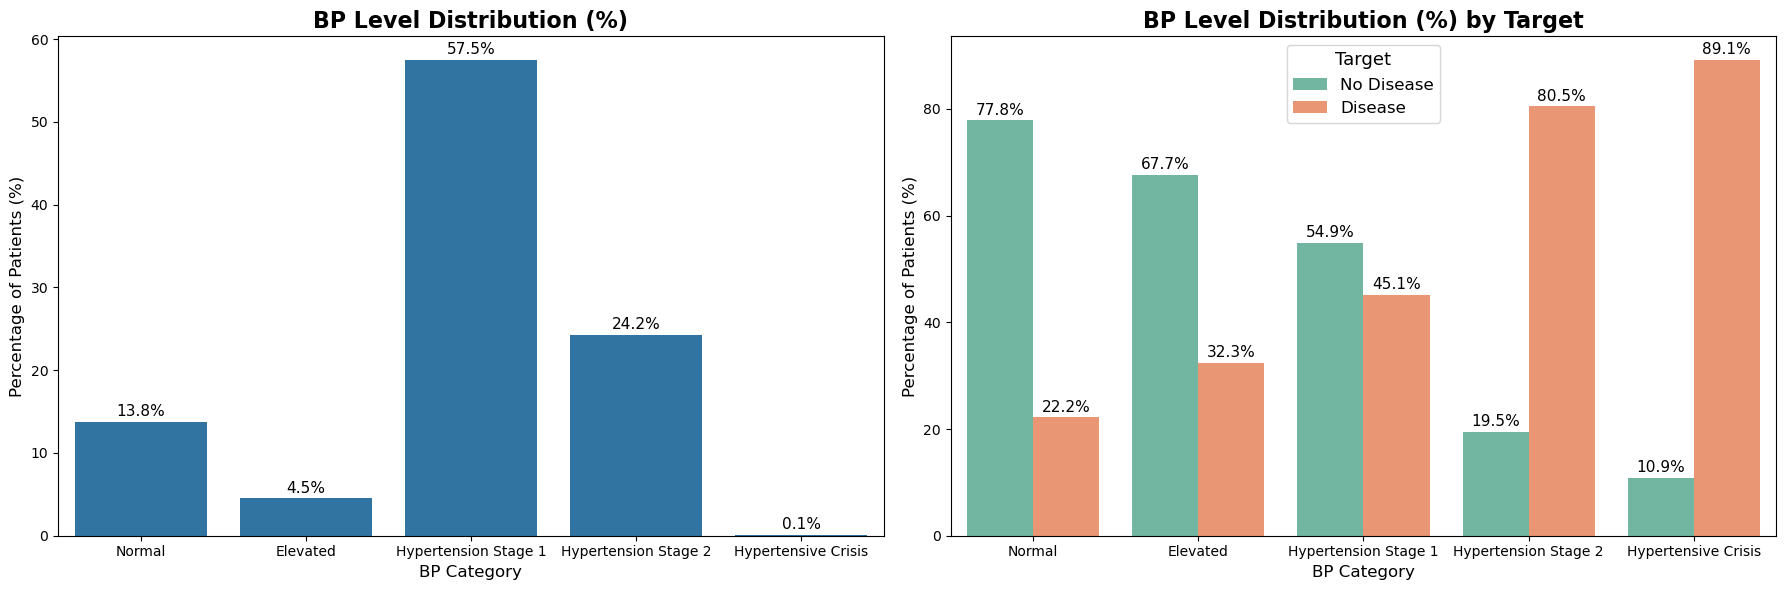

In [12]:
# --- BP Classification Function ---
def classify_bp(row):
    try:
        sbp = float(row['Systolic_BP'])
        dbp = float(row['Diastolic_BP'])
        if sbp < 0 or dbp < 0 or np.isnan(sbp) or np.isnan(dbp):
            return np.nan
    except Exception:
        return np.nan

    if sbp < 120 and dbp < 80:
        return 1  # Normal
    elif 120 <= sbp <= 129 and dbp < 80:
        return 2  # Elevated
    elif (130 <= sbp <= 139) or (80 <= dbp <= 89):
        return 3  # Hypertension Stage 1
    elif (140 <= sbp <= 180) or (90 <= dbp <= 120):
        return 4  # Hypertension Stage 2
    elif sbp > 180 or dbp > 120:
        return 5  # Hypertensive Crisis
    else:
        return np.nan

bp_labels = {
    1: 'Normal',
    2: 'Elevated',
    3: 'Hypertension Stage 1',
    4: 'Hypertension Stage 2',
    5: 'Hypertensive Crisis'
}
bp_order = list(bp_labels.values())

# --- Apply classification ---
df['BP_level'] = df.apply(classify_bp, axis=1)
df['BP_label'] = df['BP_level'].map(bp_labels)
df['BP_label'] = pd.Categorical(df['BP_label'], categories=bp_order, ordered=True)
df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

# --- Plot directory ---
plot_dir = Path('reports/visualisations/univariate_analysis')
plot_dir.mkdir(parents=True, exist_ok=True)

# --- Subplots ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.set_palette("Set2")

# --- Left: Overall distribution ---
plot_data_overall = df['BP_label'].value_counts(normalize=True).reindex(bp_order).reset_index()
plot_data_overall.columns = ['BP_label', 'percent']
plot_data_overall['percent'] *= 100

sns.barplot(
    data=plot_data_overall,
    x='BP_label', y='percent',
    order=bp_order,
    ax=axes[0]
)
axes[0].set_title('BP Level Distribution (%)', fontsize=16, weight='bold')
axes[0].set_xlabel('BP Category', fontsize=12)
axes[0].set_ylabel('Percentage of Patients (%)', fontsize=12)
axes[0].grid(False)
for c in axes[0].containers:
    axes[0].bar_label(c, fmt='%.1f%%', fontsize=11, padding=2)

# --- Right: Distribution by Target ---
plot_data_target = (
    df.dropna(subset=['BP_label', 'target_name'])
      .groupby(['BP_label', 'target_name'])
      .size()
      .reset_index(name='count')
)
total_per_bp = plot_data_target.groupby('BP_label')['count'].transform('sum')
plot_data_target['percent'] = 100 * plot_data_target['count'] / total_per_bp

sns.barplot(
    data=plot_data_target,
    x='BP_label', y='percent', hue='target_name',
    order=bp_order, ax=axes[1]
)
axes[1].set_title('BP Level Distribution (%) by Target', fontsize=16, weight='bold')
axes[1].set_xlabel('BP Category', fontsize=12)
axes[1].set_ylabel('Percentage of Patients (%)', fontsize=12)
axes[1].grid(False)
axes[1].legend(title='Target', fontsize=12, title_fontsize=13)
for c in axes[1].containers:
    axes[1].bar_label(c, fmt='%.1f%%', fontsize=11, padding=2)

plt.tight_layout()
plt.show()

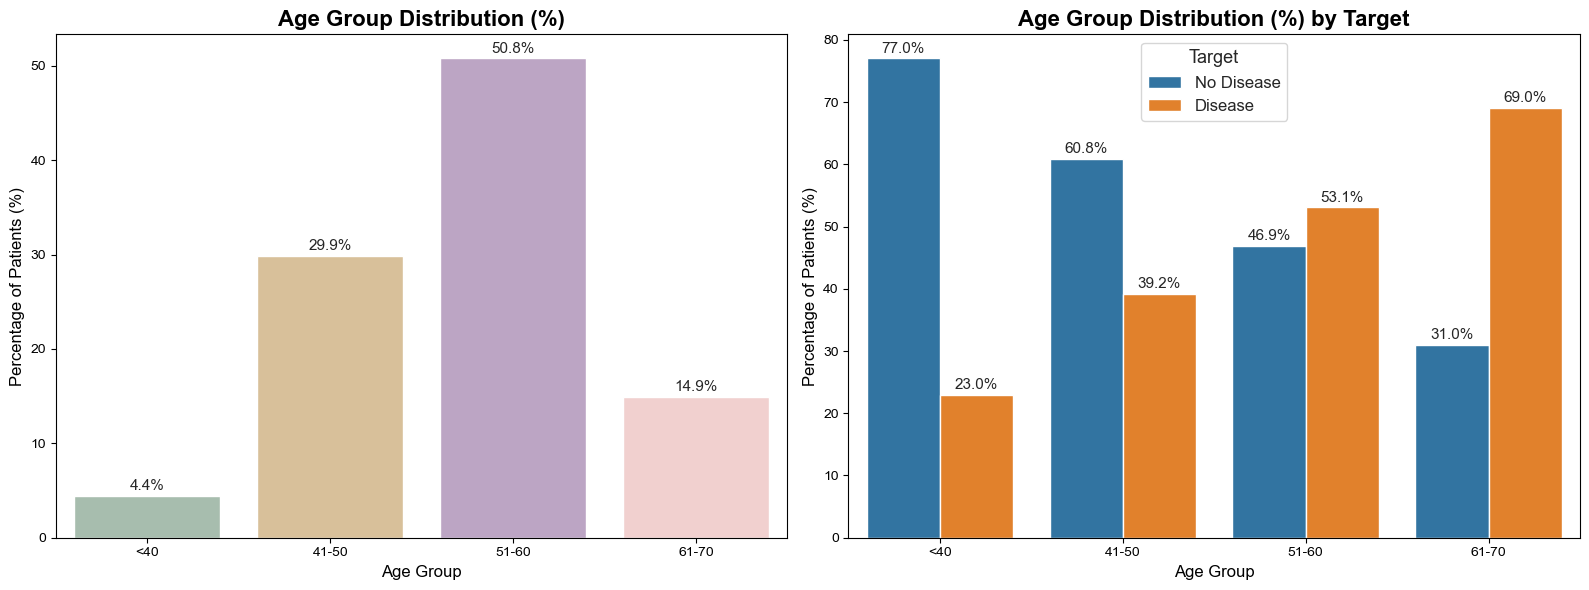

In [13]:
# --- Age Group Binning and Barplot with/without Target ---
AGE_BINS = [0, 40, 50, 60, 70, 100]
AGE_LABELS = ['<40', '41-50', '51-60', '61-70', '>70']

if 'Age_Years' in df.columns:
    # Remove invalid ages
    valid_mask = df['Age_Years'].between(AGE_BINS[0], AGE_BINS[-1])
    df = df[valid_mask].copy()

    # Create Age_Group
    df['Age_Group'] = pd.cut(df['Age_Years'], bins=AGE_BINS, labels=AGE_LABELS, right=True, include_lowest=True)

    # Only keep present age groups for plotting
    present_labels = df['Age_Group'].cat.categories[df['Age_Group'].value_counts().sort_index() > 0].tolist()

    # --- Subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.set_style("whitegrid")
    left_palette = ['#a3c1ad', '#e2c290', '#bfa0c9', '#f7cac9', '#7b9acc']  # Soft, non-blue/orange colors
    right_palette = ['#1f77b4', '#ff7f0e']

    # --- Left: Overall distribution (no target label, different colors) ---
    plot_data_overall = df['Age_Group'].value_counts(normalize=True).reindex(present_labels).reset_index()
    plot_data_overall.columns = ['Age_Group', 'percent']
    plot_data_overall['percent'] *= 100

    sns.barplot(
        data=plot_data_overall,
        x='Age_Group', y='percent',
        order=present_labels,
        ax=axes[0],
        palette=left_palette
    )
    axes[0].set_title('Age Group Distribution (%)', fontsize=16, weight='bold')
    axes[0].set_xlabel('Age Group', fontsize=12)
    axes[0].set_ylabel('Percentage of Patients (%)', fontsize=12)
    axes[0].grid(False)
    for c in axes[0].containers:
        axes[0].bar_label(c, fmt='%.1f%%', fontsize=11, padding=2)

    # --- Right: Distribution by Target (target label, blue/orange) ---
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})
    plot_data_target = (
        df.dropna(subset=['Age_Group', 'target_name'])
          .groupby(['Age_Group', 'target_name'])
          .size()
          .reset_index(name='count')
    )
    total_per_group = plot_data_target.groupby('Age_Group')['count'].transform('sum')
    plot_data_target['percent'] = 100 * plot_data_target['count'] / total_per_group

    sns.barplot(
        data=plot_data_target,
        x='Age_Group', y='percent', hue='target_name',
        order=present_labels,
        ax=axes[1],
        palette=right_palette
    )
    axes[1].set_title('Age Group Distribution (%) by Target', fontsize=16, weight='bold')
    axes[1].set_xlabel('Age Group', fontsize=12)
    axes[1].set_ylabel('Percentage of Patients (%)', fontsize=12)
    axes[1].grid(False)
    axes[1].legend(title='Target', fontsize=12, title_fontsize=13)
    for c in axes[1].containers:
        axes[1].bar_label(c, fmt='%.1f%%', fontsize=11, padding=2)

    plt.tight_layout()
    plt.show()

    # --- Cleanup ---
    df = df.drop(['target_name'], axis=1, errors='ignore')

# Cleanup variables
del AGE_BINS, AGE_LABELS, valid_mask, present_labels, plot_data_overall, plot_data_target, total_per_group

### **Observations:**

* **Patient Population**
The study is mostly focused on middle-aged people. **Over half of all patients are in their 50s**.

* **Disease Risk by Age**
Age is a massive risk factor. The link is very clear: the older you get, the higher the risk of disease.

* **Key Insight**
While the largest group of patients is in their 50s, the **highest risk of disease** is found in the oldest group (`61-70`). The chance of having the disease **triples** from the youngest group (23%) to the oldest group (69%).

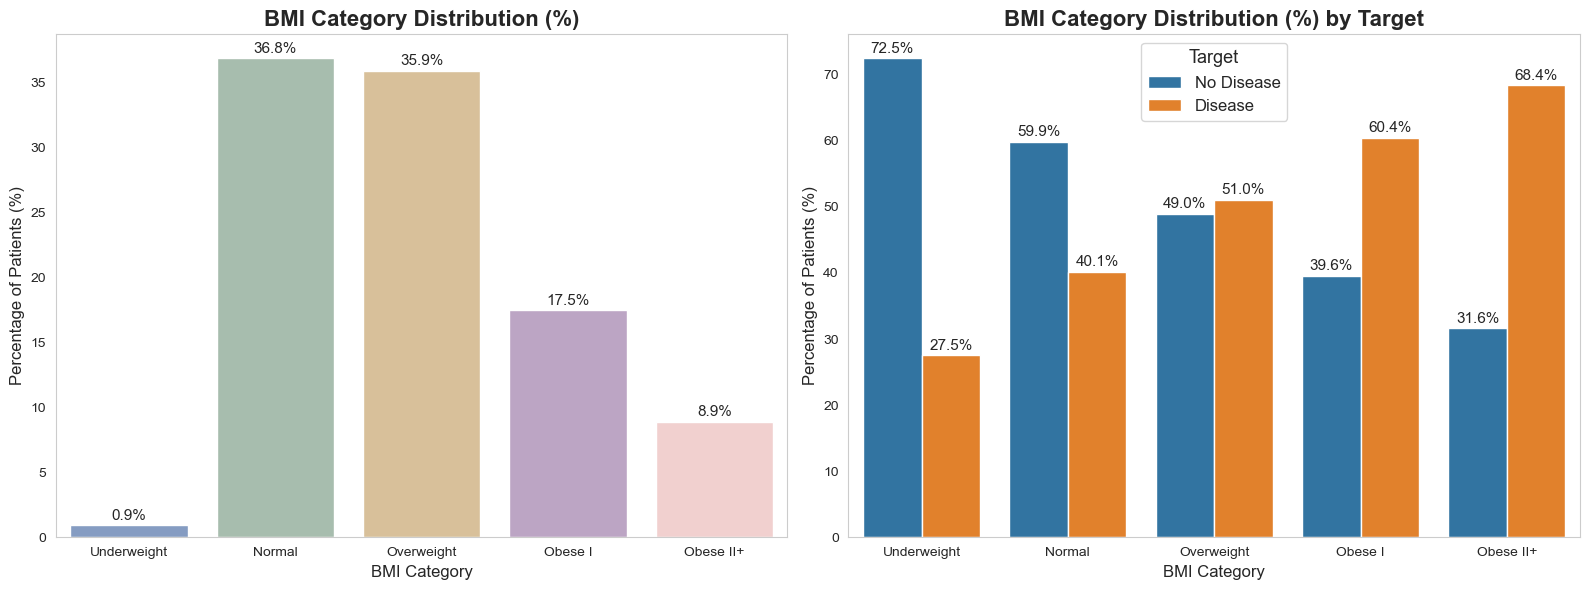

In [14]:
# ---------------------------
# BMI Categorization and Barplot with/without Target
# ---------------------------
BMI_BINS = [0, 18.5, 25, 30, 35, float('inf')]
BMI_LABELS = ['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II+']

if 'BMI' in df.columns:
    # Create BMI_Category
    df['BMI_Category'] = pd.cut(df['BMI'], bins=BMI_BINS, labels=BMI_LABELS, right=False)

    # Map target for right plot only
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

    # --- Subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.set_style("whitegrid")
    left_palette = ['#7b9acc', '#a3c1ad', '#e2c290', '#bfa0c9', '#f7cac9']  # Soft, non-blue/orange colors
    right_palette = ['#1f77b4', '#ff7f0e']

    # --- Left: Overall distribution (no target label, different colors) ---
    plot_data_overall = df['BMI_Category'].value_counts(normalize=True).reindex(BMI_LABELS).reset_index()
    plot_data_overall.columns = ['BMI_Category', 'percent']
    plot_data_overall['percent'] *= 100

    sns.barplot(
        data=plot_data_overall,
        x='BMI_Category', y='percent',
        order=BMI_LABELS,
        ax=axes[0],
        palette=left_palette
    )
    axes[0].set_title('BMI Category Distribution (%)', fontsize=16, weight='bold')
    axes[0].set_xlabel('BMI Category', fontsize=12)
    axes[0].set_ylabel('Percentage of Patients (%)', fontsize=12)
    axes[0].grid(False)
    for c in axes[0].containers:
        axes[0].bar_label(c, fmt='%.1f%%', fontsize=11, padding=2)

    # --- Right: Distribution by Target (target label, blue/orange) ---
    plot_data_target = (
        df.dropna(subset=['BMI_Category', 'target_name'])
          .groupby(['BMI_Category', 'target_name'])
          .size()
          .reset_index(name='count')
    )
    total_per_category = plot_data_target.groupby('BMI_Category')['count'].transform('sum')
    plot_data_target['percent'] = 100 * plot_data_target['count'] / total_per_category

    sns.barplot(
        data=plot_data_target,
        x='BMI_Category', y='percent', hue='target_name',
        order=BMI_LABELS,
        ax=axes[1],
        palette=right_palette
    )
    axes[1].set_title('BMI Category Distribution (%) by Target', fontsize=16, weight='bold')
    axes[1].set_xlabel('BMI Category', fontsize=12)
    axes[1].set_ylabel('Percentage of Patients (%)', fontsize=12)
    axes[1].grid(False)
    axes[1].legend(title='Target', fontsize=12, title_fontsize=13)
    for c in axes[1].containers:
        axes[1].bar_label(c, fmt='%.1f%%', fontsize=11, padding=2)

    plt.tight_layout()
    plt.show()

    # --- Cleanup ---
    df.drop(['target_name'], axis=1, inplace=True, errors='ignore')

# Cleanup variables
del BMI_BINS, BMI_LABELS, plot_data_overall, plot_data_target, total_per_category

### **Patient Population**
Most of the patients in this study fall into the **'Normal'** or **'Overweight'** BMI groups, which are almost equal in size. Very few people in this group are underweight.

**Disease Risk by BMI**
Higher BMI is a **major risk factor**. The trend is very clear: as the BMI category increases, the chance of having the disease gets progressively higher.

**Key Insight**
The risk of disease climbs steadily from one category to the next. The chance of having the disease is lowest for 'Underweight' people (27.5%) and highest for the most obese group (**68.4%**).

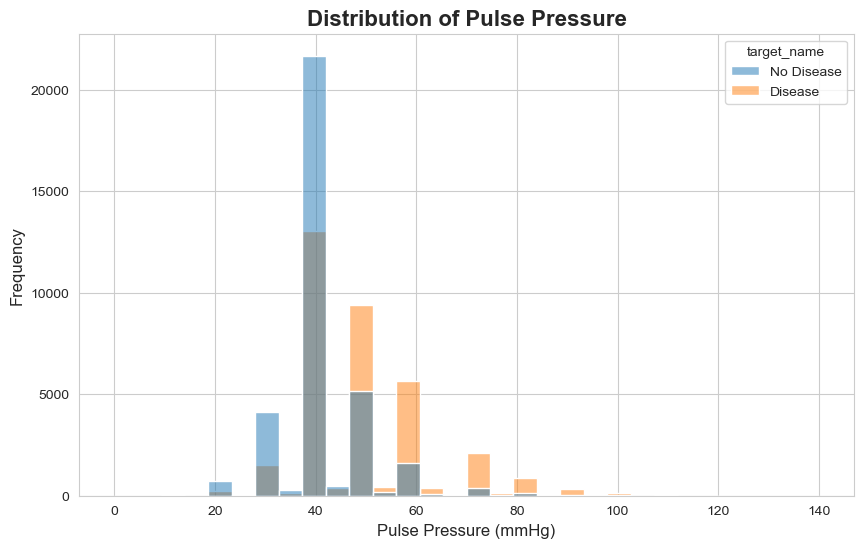

In [15]:
# feature engineering --- Pulse Pressure
df['Pulse_Pressure'] = df['Systolic_BP'] - df['Diastolic_BP']

# Ensure target_name is defined for plotting
if 'target_name' not in df.columns:
	df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

# Define TARGET_PALETTE if not already defined
TARGET_PALETTE = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}

# plot distribution of Pulse Pressure
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Pulse_Pressure', hue='target_name', bins=30, kde=False, palette=TARGET_PALETTE)
plt.title('Distribution of Pulse Pressure', fontsize=16, weight='bold')
plt.xlabel('Pulse Pressure (mmHg)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [16]:
# Check missing % per column
missing_pct = df.isna().mean() * 100
missing_pct

Age_Years            0.0
Sex                  0.0
Systolic_BP          0.0
Diastolic_BP         0.0
Cholesterol_Level    0.0
Glucose_Level        0.0
Smoking_Status       0.0
Alcohol_Intake       0.0
Physical_Activity    0.0
target               0.0
BMI                  0.0
BP_level             0.0
BP_label             0.0
Age_Group            0.0
BMI_Category         0.0
Pulse_Pressure       0.0
target_name          0.0
dtype: float64

# Exploratory Data Analysis

### Numerical Analysis

[INFO] Folder already exists: P:\projects\heart disease prediction\reports\visualizations\univariate analysis\numerical analysis


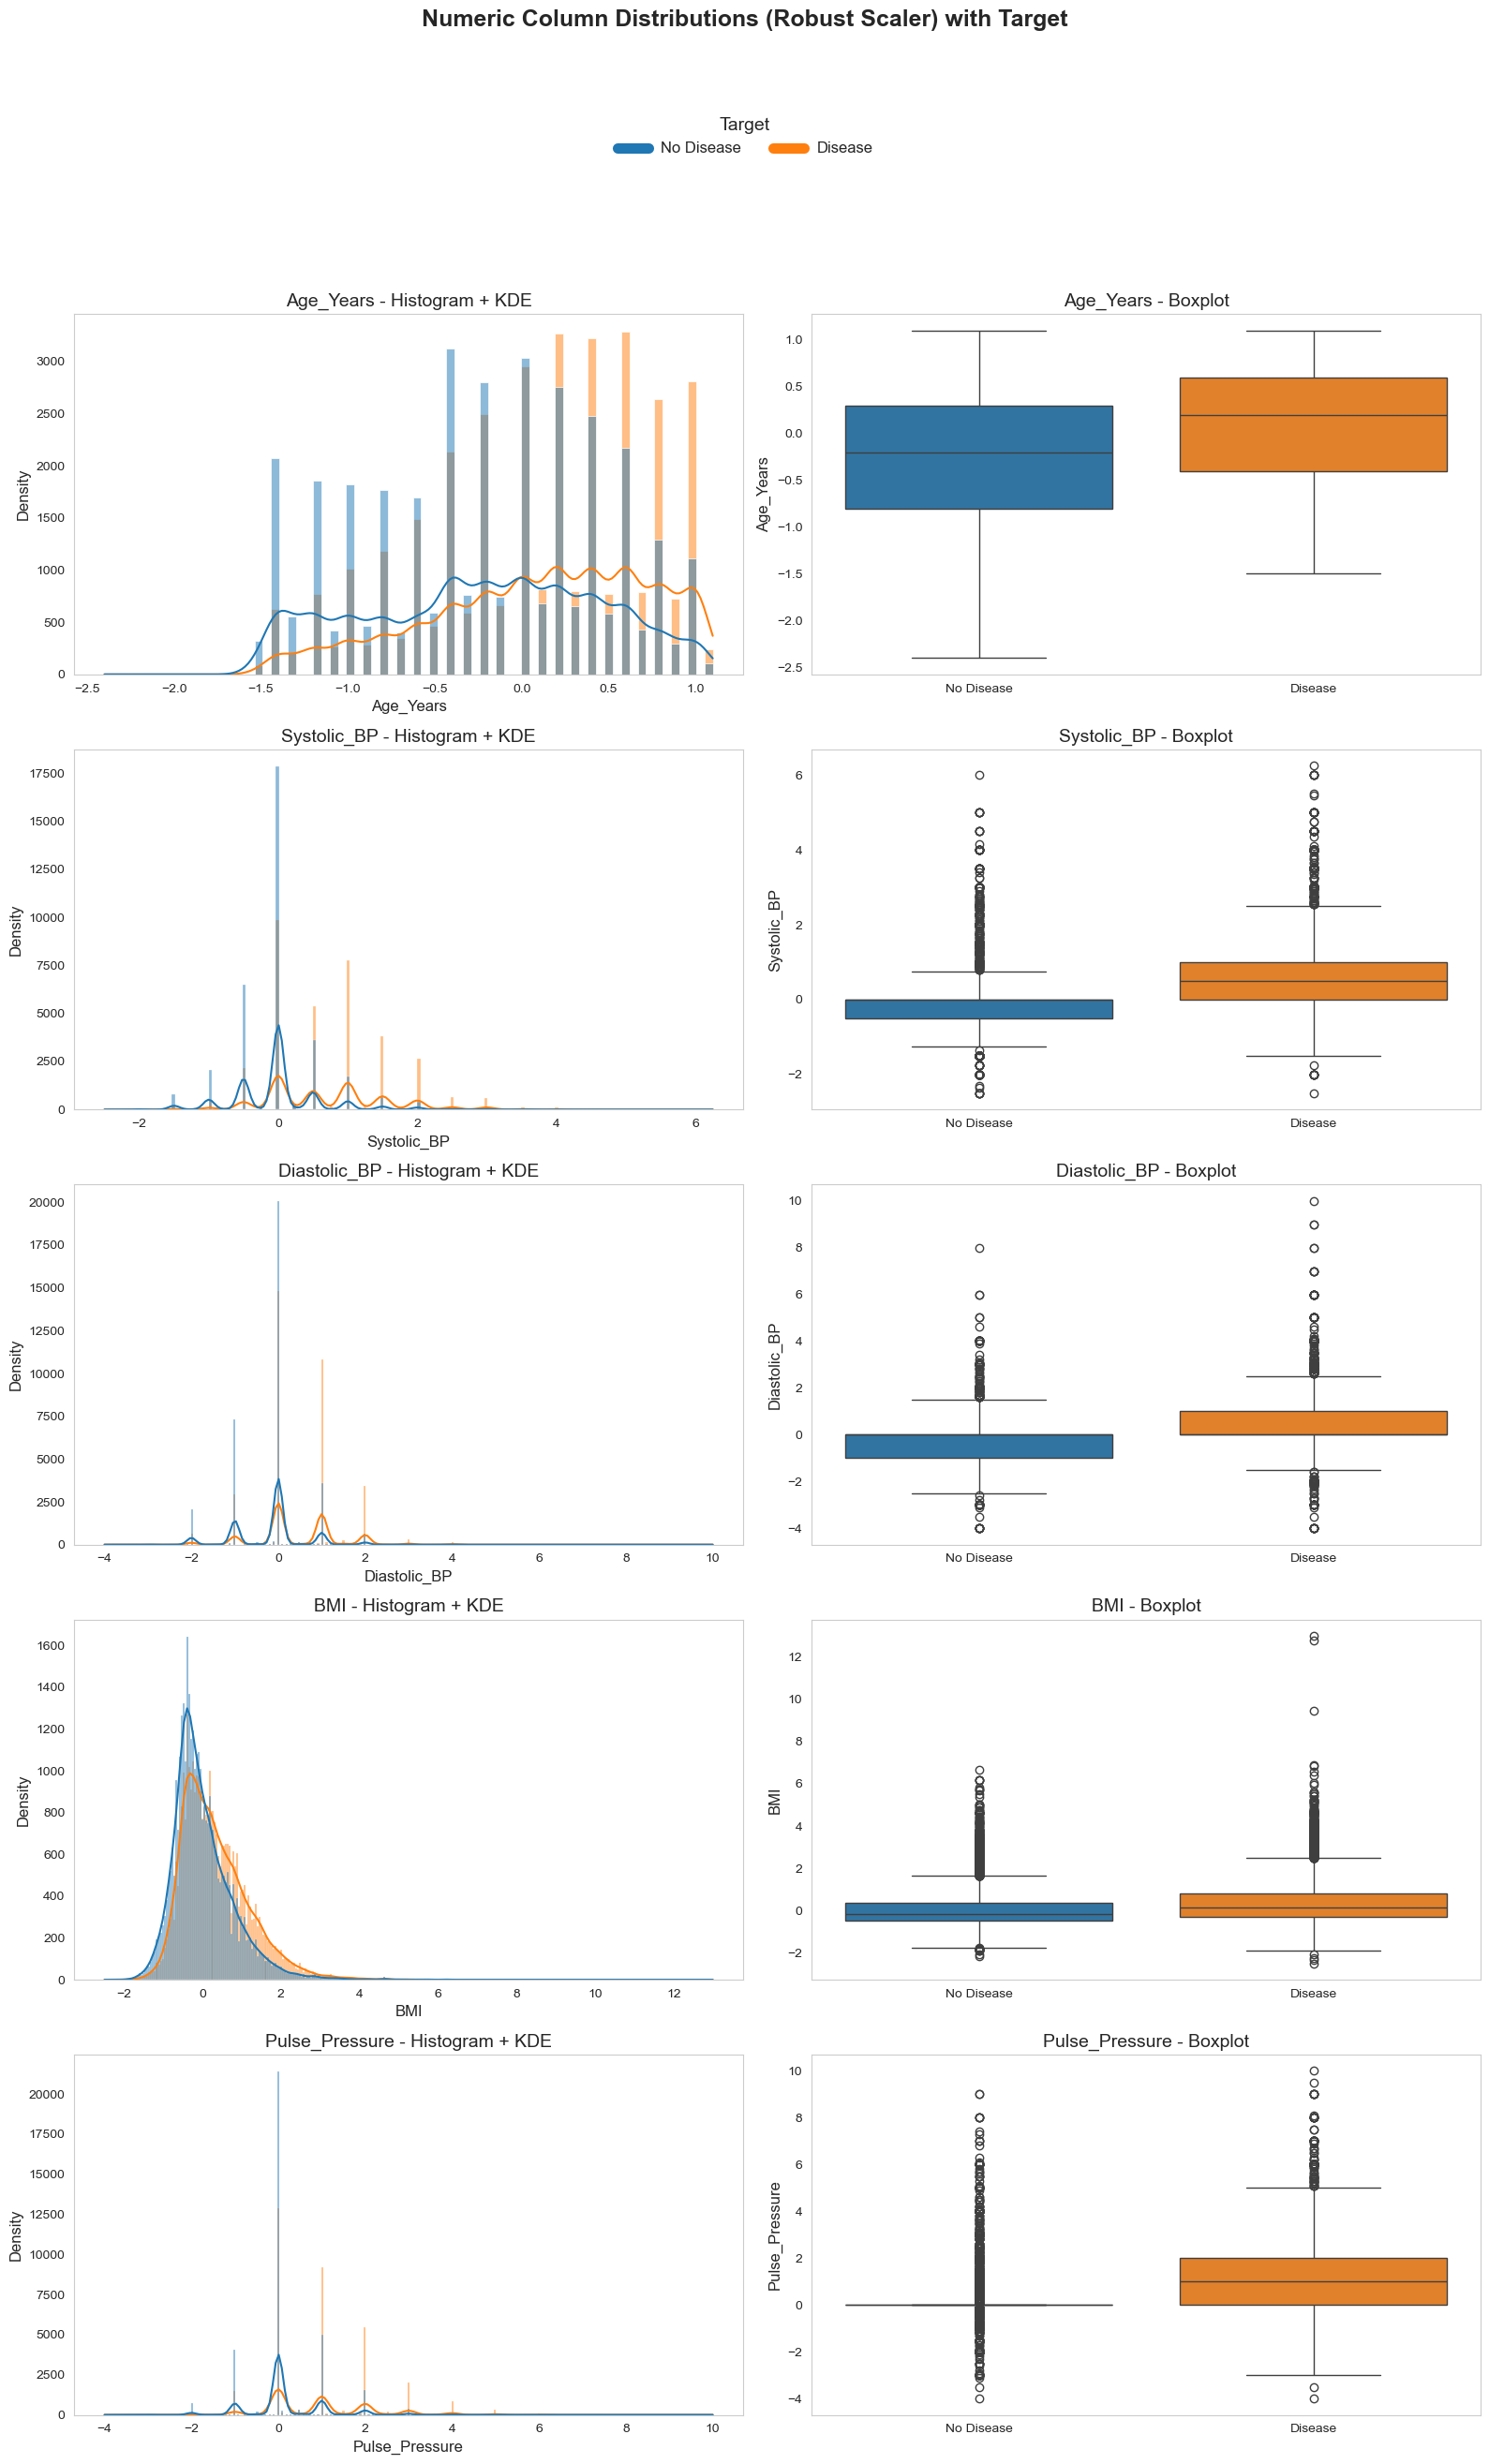

[SUCCESS] Plot saved (overwritten if existed) to: P:\projects\heart disease prediction\reports\visualizations\univariate analysis\numerical analysis\01_Numeric_Columns_Distributions_RobustScaler.png


In [30]:
# ---------------------------
# Columns to scale
# ---------------------------
numeric_cols = ['Age_Years', 'Systolic_BP', 'Diastolic_BP', 'BMI', 'Pulse_Pressure']

# ---------------------------
# Target mapping
# ---------------------------
if 'target_name' not in df.columns and 'target' in df.columns:
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

TARGET_PALETTE = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}

# ---------------------------
# Apply RobustScaler on original data
# ---------------------------
scaler = RobustScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# ---------------------------
# Figure layout: 2 columns per row
# ---------------------------
n_rows = len(numeric_cols)
fig, axes = plt.subplots(n_rows, 2, figsize=(16, 5 * n_rows), squeeze=False)

# Main title
fig.suptitle(
    'Numeric Column Distributions (Robust Scaler) with Target',
    fontsize=18, weight='bold', y=1.05
)

# ---------------------------
# Plotting
# ---------------------------
for i, col in enumerate(numeric_cols):
    data_plot = pd.DataFrame({'Value': df[col], 'target_name': df['target_name']})

    # --- Left: Histogram + KDE ---
    sns.histplot(
        data=data_plot, x='Value', hue='target_name', palette=TARGET_PALETTE,
        kde=True, ax=axes[i, 0], legend=False
    )
    axes[i, 0].set_title(f'{col} - Histogram + KDE', fontsize=14)
    axes[i, 0].set_xlabel(col, fontsize=12)
    axes[i, 0].set_ylabel('Density', fontsize=12)
    axes[i, 0].tick_params(axis='both', labelsize=10)
    axes[i, 0].grid(False)

    # --- Right: Boxplot ---
    sns.boxplot(
        data=data_plot, x='target_name', y='Value',
        palette=TARGET_PALETTE, ax=axes[i, 1], dodge=False, showfliers=True
    )
    axes[i, 1].set_title(f'{col} - Boxplot', fontsize=14)
    axes[i, 1].set_xlabel('')
    axes[i, 1].set_ylabel(col, fontsize=12)
    axes[i, 1].tick_params(axis='both', labelsize=10)
    axes[i, 1].grid(False)
    axes[i, 1].set_xticklabels(list(TARGET_PALETTE.keys()))

# ---------------------------
# Single horizontal legend below title
# ---------------------------
handles = [Line2D([0], [0], color=TARGET_PALETTE[name], lw=8, label=name) for name in TARGET_PALETTE]
fig.legend(
    handles=handles, labels=list(TARGET_PALETTE.keys()), title='Target',
    title_fontsize=14, fontsize=12, loc='upper center', bbox_to_anchor=(0.5, 1.01),
    ncol=len(TARGET_PALETTE), frameon=False
)

plt.tight_layout(rect=(0, 0, 1, 0.95))

# ---------------------------
# Save figure outside src, only create folder if missing
# ---------------------------
PROJECT_ROOT = Path.cwd().parent.parent.resolve()  # Two levels up from src
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate analysis' / 'numerical analysis'

if not PLOT_DIR.exists():  # Only create if folder is missing
    PLOT_DIR.mkdir(parents=True)
    print(f"[INFO] Created folder: {PLOT_DIR.resolve()}")
else:
    print(f"[INFO] Folder already exists: {PLOT_DIR.resolve()}")

img_path = PLOT_DIR / '01_Numeric_Columns_Distributions_RobustScaler.png'

# Remove previous file if exists
if img_path.exists():
    img_path.unlink()

plt.savefig(img_path, bbox_inches='tight', dpi=150)
plt.show()
print(f"[SUCCESS] Plot saved (overwritten if existed) to: {img_path.resolve()}")

***Observations:***

* ***Age is a Major Factor:*** The charts clearly show that patients with the disease are older.

* ***Blood Pressure is a Strong Sign:*** All blood pressure readings (Systolic, Diastolic, and Pulse Pressure) are noticeably higher in the group with the disease.

* ***BMI Shows a Connection:*** Higher BMI is linked to the disease, but the difference between the groups is less dramatic than it is for age and blood pressure.

***Main Takeaway:*** While all the metrics are important, age and high blood pressure are the strongest and most obvious indicators of the disease in these graphs.

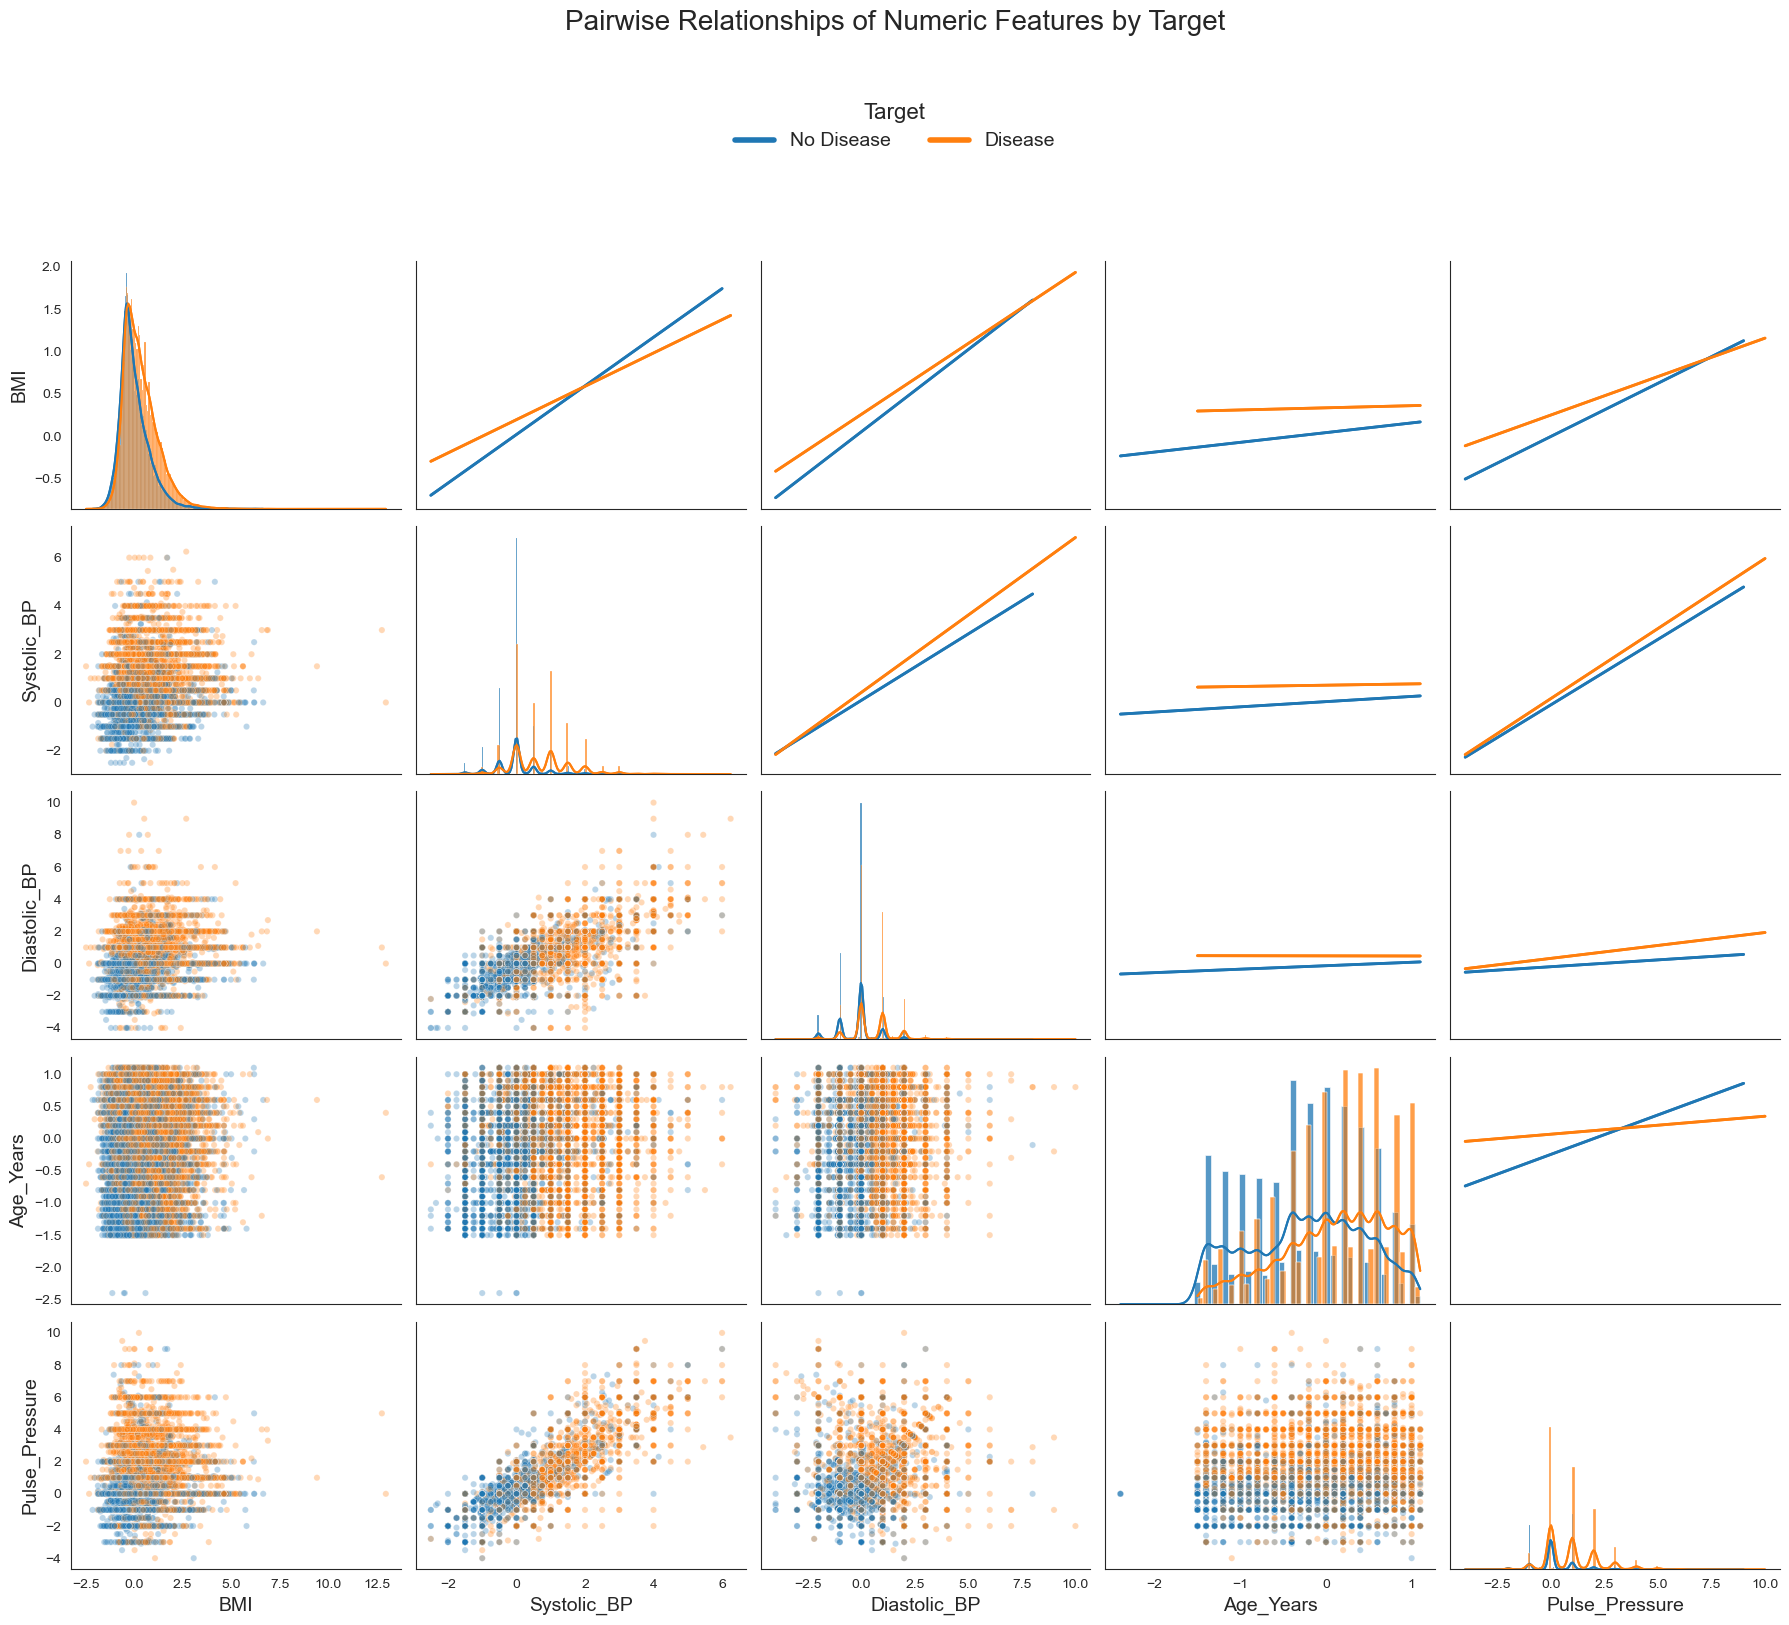

[SUCCESS] Plot saved (overwritten if existed) to: P:\projects\heart disease prediction\reports\visualizations\univariate analysis\numerical analysis\02_Pairwise_Relationships_of_Numeric_Features.png


In [18]:
# ---------------------------
# Project root and plot directory outside src
# ---------------------------
PROJECT_ROOT = Path.cwd().parent.parent.resolve()  # two levels up from src/notebooks
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate analysis' / 'numerical analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)  # create folder only if missing

# ---------------------------
# Numeric columns
# ---------------------------
numeric_cols = ['BMI', 'Systolic_BP', 'Diastolic_BP', 'Age_Years', 'Pulse_Pressure']

# ---------------------------
# Target palette
# ---------------------------
TARGET_PALETTE_LIST = ['#1f77b4', '#ff7f0e']
PAIRGRID_PALETTE = {v: c for v, c in zip(['No Disease', 'Disease'], TARGET_PALETTE_LIST)}

# ---------------------------
# Prepare DataFrame
# ---------------------------
df_plot = df.copy()
df_plot['target_name'] = df_plot['target'].map({0: 'No Disease', 1: 'Disease'})

# ---------------------------
# Styling
# ---------------------------
plt.rcParams['axes.grid'] = False
sns.set_style("white")  # no grid lines

# ---------------------------
# Initialize PairGrid
# ---------------------------
g = sns.PairGrid(
    df_plot,
    vars=numeric_cols,
    hue='target_name',
    palette=PAIRGRID_PALETTE,
    diag_sharey=False,
    height=3,
    aspect=1.2
)

# ---------------------------
# Upper: regression lines
# ---------------------------
def reg_by_target(x, y, **kwargs):
    for name, color in PAIRGRID_PALETTE.items():
        subset = df_plot[df_plot['target_name'] == name]
        if subset[x.name].notna().sum() > 1 and subset[y.name].notna().sum() > 1:
            sns.regplot(
                x=subset[x.name], y=subset[y.name], scatter=False, ci=None,
                line_kws={'color': color, 'label': name, 'linewidth': 2}, ax=plt.gca()
            )

g.map_upper(reg_by_target)

# ---------------------------
# Lower: scatter plot
# ---------------------------
g.map_lower(sns.scatterplot, alpha=0.3, s=20)

# ---------------------------
# Diagonal: histogram
# ---------------------------
def hist_diag(x, **kwargs):
    ax = plt.gca()
    for name, color in PAIRGRID_PALETTE.items():
        subset = df_plot[df_plot['target_name'] == name]
        if subset[x.name].notna().sum() > 1:
            sns.histplot(subset[x.name], color=color, alpha=0.5, kde=True, ax=ax)
    if ax.get_legend():
        ax.get_legend().remove()

g.map_diag(hist_diag)

# ---------------------------
# Main title
# ---------------------------
plt.suptitle('Pairwise Relationships of Numeric Features by Target', fontsize=20, y=1.08)

# ---------------------------
# Legend below title
# ---------------------------
handles = [plt.Line2D([0], [0], color=color, lw=4, label=name) for name, color in PAIRGRID_PALETTE.items()]
labels = list(PAIRGRID_PALETTE.keys())
g.figure.legend(
    handles, labels, title='Target', title_fontsize=16, fontsize=14,
    loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=2, frameon=False
)

# ---------------------------
# Axis labels font size
# ---------------------------
for i, var in enumerate(numeric_cols):
    g.axes[i, 0].set_ylabel(var, fontsize=14)
    g.axes[-1, i].set_xlabel(var, fontsize=14)

plt.tight_layout(rect=(0, 0, 1, 0.95))

# ---------------------------
# Remove grid lines from all axes
# ---------------------------
for ax_row in g.axes:
    for ax in ax_row:
        ax.grid(False)

# ---------------------------
# Save figure robustly with overwrite
# ---------------------------
img_path = PLOT_DIR / '02_Pairwise_Relationships_of_Numeric_Features.png'
try:
    if img_path.exists():
        img_path.unlink()  # Remove previous file to overwrite
    plt.savefig(img_path, bbox_inches='tight', dpi=150)
    plt.show()
    print(f"[SUCCESS] Plot saved (overwritten if existed) to: {img_path.resolve()}")
except Exception as e:
    print(f"[ERROR] Could not save plot: {e}")

### ***Observations:***

* ***Age is the biggest factor:*** Older people are much more likely to have the disease.

* ***High blood pressure is a clear sign:*** People with the disease tend to have higher systolic, diastolic, and pulse pressure readings.

* ***Higher BMI is also linked:*** A higher BMI increases the chances of having the disease, though it's not as strong a factor as age or blood pressure.

***Risks add up:*** The data shows that the highest concentration of disease is among older individuals with high blood pressure.

In [19]:
# ==============================================================================
# NUMERICAL ANALYSIS: Statistical Comparison & Correlation (Strength & Direction)
# ==============================================================================
from scipy.stats import mannwhitneyu, spearmanr

numeric_cols = ['Age_Years', 'BMI', 'Systolic_BP', 'Diastolic_BP', 'Pulse_Pressure']
target_col = 'target'

results = []

for col in numeric_cols:
    group0 = df[df[target_col] == 0][col]
    group1 = df[df[target_col] == 1][col]
    
    stat, p_mwu = mannwhitneyu(group0, group1, alternative='two-sided')
    
    median0 = group0.median()
    median1 = group1.median()
    
    # --- Robust Direction Logic ---
    # This handles the case where medians are equal, avoiding a misleading result.
    if median1 > median0:
        mwu_direction = "higher"
    elif median1 < median0:
        mwu_direction = "lower"
    else:
        mwu_direction = "equal"
        
    corr, p_corr = spearmanr(df[col], df[target_col], nan_policy='omit')
    
    strength = "strong" if abs(corr) > 0.5 else "moderate" if abs(corr) > 0.3 else "weak"
    corr_direction = "positive" if corr > 0 else "negative"
    
    results.append({
        "Feature": col,
        "MWU_p": p_mwu,
        "Median_NoDisease": median0,
        "Median_Disease": median1,
        "MWU_Direction": mwu_direction,
        "Spearman_r": corr,
        "Spearman_p": p_corr,
        "Strength": strength,
        "Corr_Direction": corr_direction
    })

results_df = pd.DataFrame(results)
display(results_df)


,Feature,MWU_p,Median_NoDisease,Median_Disease,MWU_Direction,Spearman_r,Spearman_p,Strength,Corr_Direction
0,Age_Years,0.0,-0.200000,0.200000,higher,0.235279,0.0,weak,positive
1,BMI,0.0,-0.141738,0.174662,higher,0.199479,0.0,weak,positive
2,Systolic_BP,0.0,0.000000,0.500000,higher,0.456553,0.0,moderate,positive
3,Diastolic_BP,0.0,0.000000,0.000000,equal,0.364012,0.0,moderate,positive
4,Pulse_Pressure,0.0,0.000000,1.000000,higher,0.364430,0.0,moderate,positive


### ***Observations:***

* **Overall Trend:** Both the graphs and the statistics show that higher numbers for **Age, BMI, and all blood pressure measurements** are linked to having the disease.

* **Strongest Factor:** **Systolic BP** is the most important factor. The difference between the 'Disease' and 'No Disease' groups is very clear in the graph, and the stats confirm it has the strongest connection.

* **Moderate Factors:** **Pulse Pressure** and **Diastolic BP** have a moderate connection to the disease. Interestingly, even though the median **Diastolic BP** is the same for both groups, the overall trend still points toward a link with the disease.

* **Weakest Factors:** **Age** and **BMI** are the weakest predictors. You can see a lot of overlap between the groups in the graph, which the stats confirm.

### Categorical Analysis

In [20]:
# Demographics and physical metrics combined.
demographics = ['Age_Group', 'Sex', 'BMI_group']

# Clinical Biomarkers: Lab results and clinical measurements.
clinical_biomarkers = ['Cholesterol_Level', 'Glucose_Level', 'BP_label']

# Lifestyle Factors: Behavioral habits.
lifestyle = ['Smoking', 'Alcohol', 'Physical_Activity']

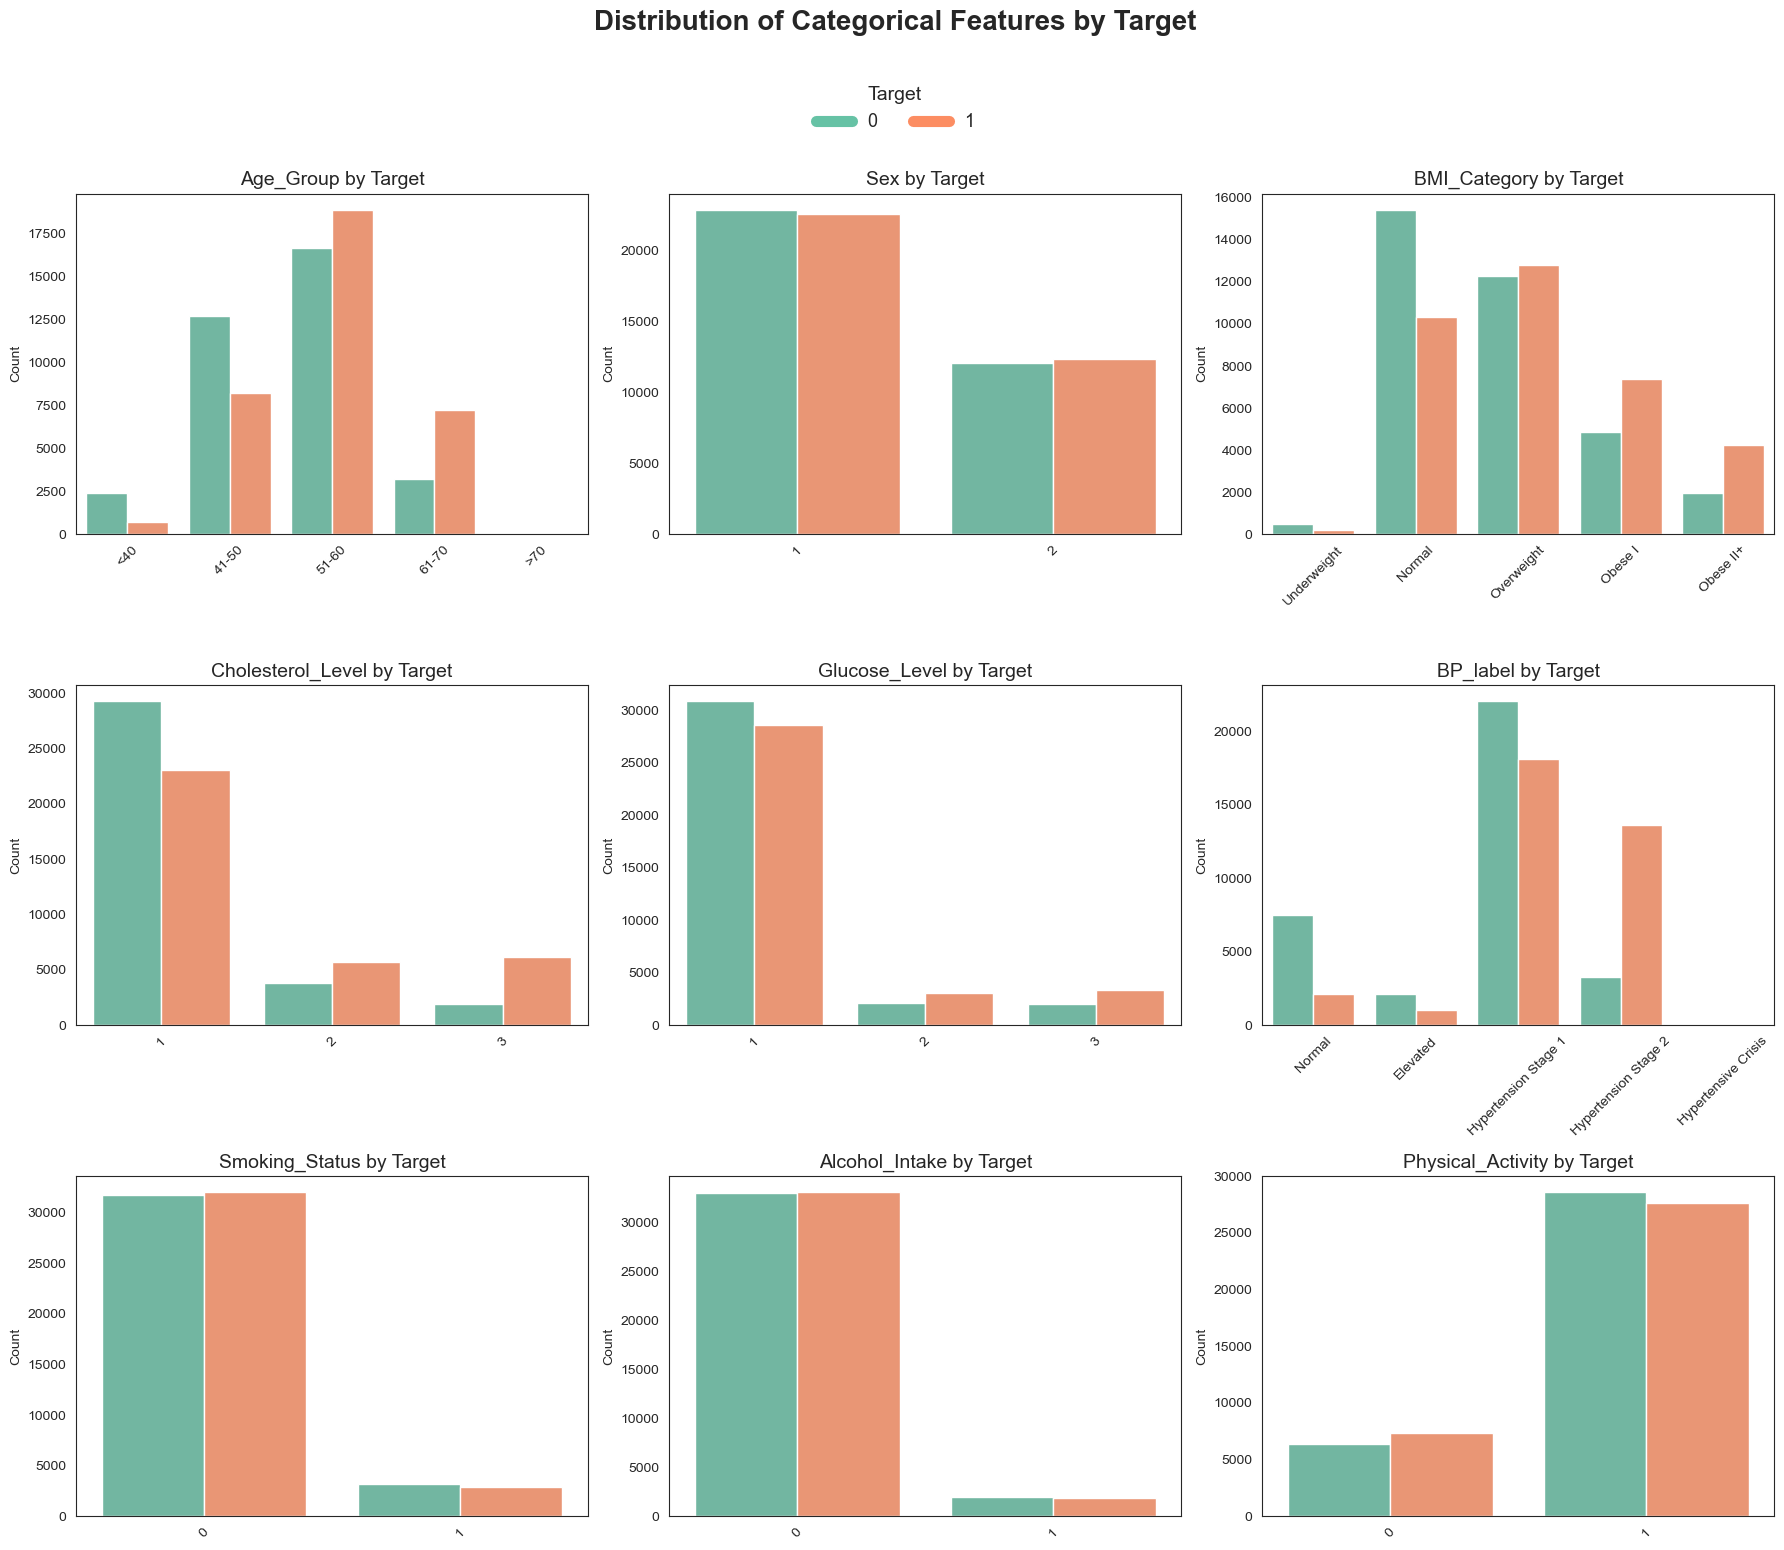

[SUCCESS] Plot saved to: P:\projects\heart disease prediction\reports\visualizations\univariate analysis\categorical analysis\01_Categorical_Distributions_by_Target.png


In [21]:
# --- Categorical features ---
cat_cols = [
    'Age_Group', 'Sex', 'BMI_Category', 'Cholesterol_Level', 'Glucose_Level',
    'BP_label', 'Smoking_Status', 'Alcohol_Intake', 'Physical_Activity'
]

# --- Layout ---
n_cols = 3
n_rows = (len(cat_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
sns.set_style("whitegrid")
axes = axes.flatten()

fig.suptitle('Distribution of Categorical Features by Target',
             fontsize=20, weight='bold', y=1.03)

# --- Plot each categorical variable ---
for i, col in enumerate(cat_cols):
    ax = axes[i]
    
    plot_df = df[[col, 'target']].copy()

    # Convert numeric codes to strings for plotting
    if pd.api.types.is_numeric_dtype(plot_df[col]):
        plot_df[col] = plot_df[col].astype(str)

    # Plot grouped countplot
    sns.countplot(
        data=plot_df,
        x=col,
        hue='target',  # keep original target values
        palette='Set2',
        ax=ax,
        dodge=True,
        legend=False
    )

    ax.set_title(f'{col} by Target', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

# --- Hide unused axes ---
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=(0, 0, 1, 0.96))

# --- Legend ---
handles = [
    Line2D([0], [0], color=sns.color_palette('Set2')[0], lw=8, label='0'),
    Line2D([0], [0], color=sns.color_palette('Set2')[1], lw=8, label='1')
]
fig.legend(
    handles=handles,
    labels=['0', '1'],  # keep target as is
    title='Target',
    loc='upper center',
    bbox_to_anchor=(0.5, 0.99),
    ncol=2,
    frameon=False,
    fontsize=13,
    title_fontsize=14
)

# --- Save plot ---
PLOT_DIR = Path.cwd().parent.parent / 'reports' / 'visualizations' / 'univariate analysis' / 'categorical analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)

img_path = PLOT_DIR / '01_Categorical_Distributions_by_Target.png'
plt.savefig(img_path, bbox_inches='tight', dpi=150)
plt.show()

print(f"[SUCCESS] Plot saved to: {img_path.resolve()}")

### -> Clinical_biomarkers

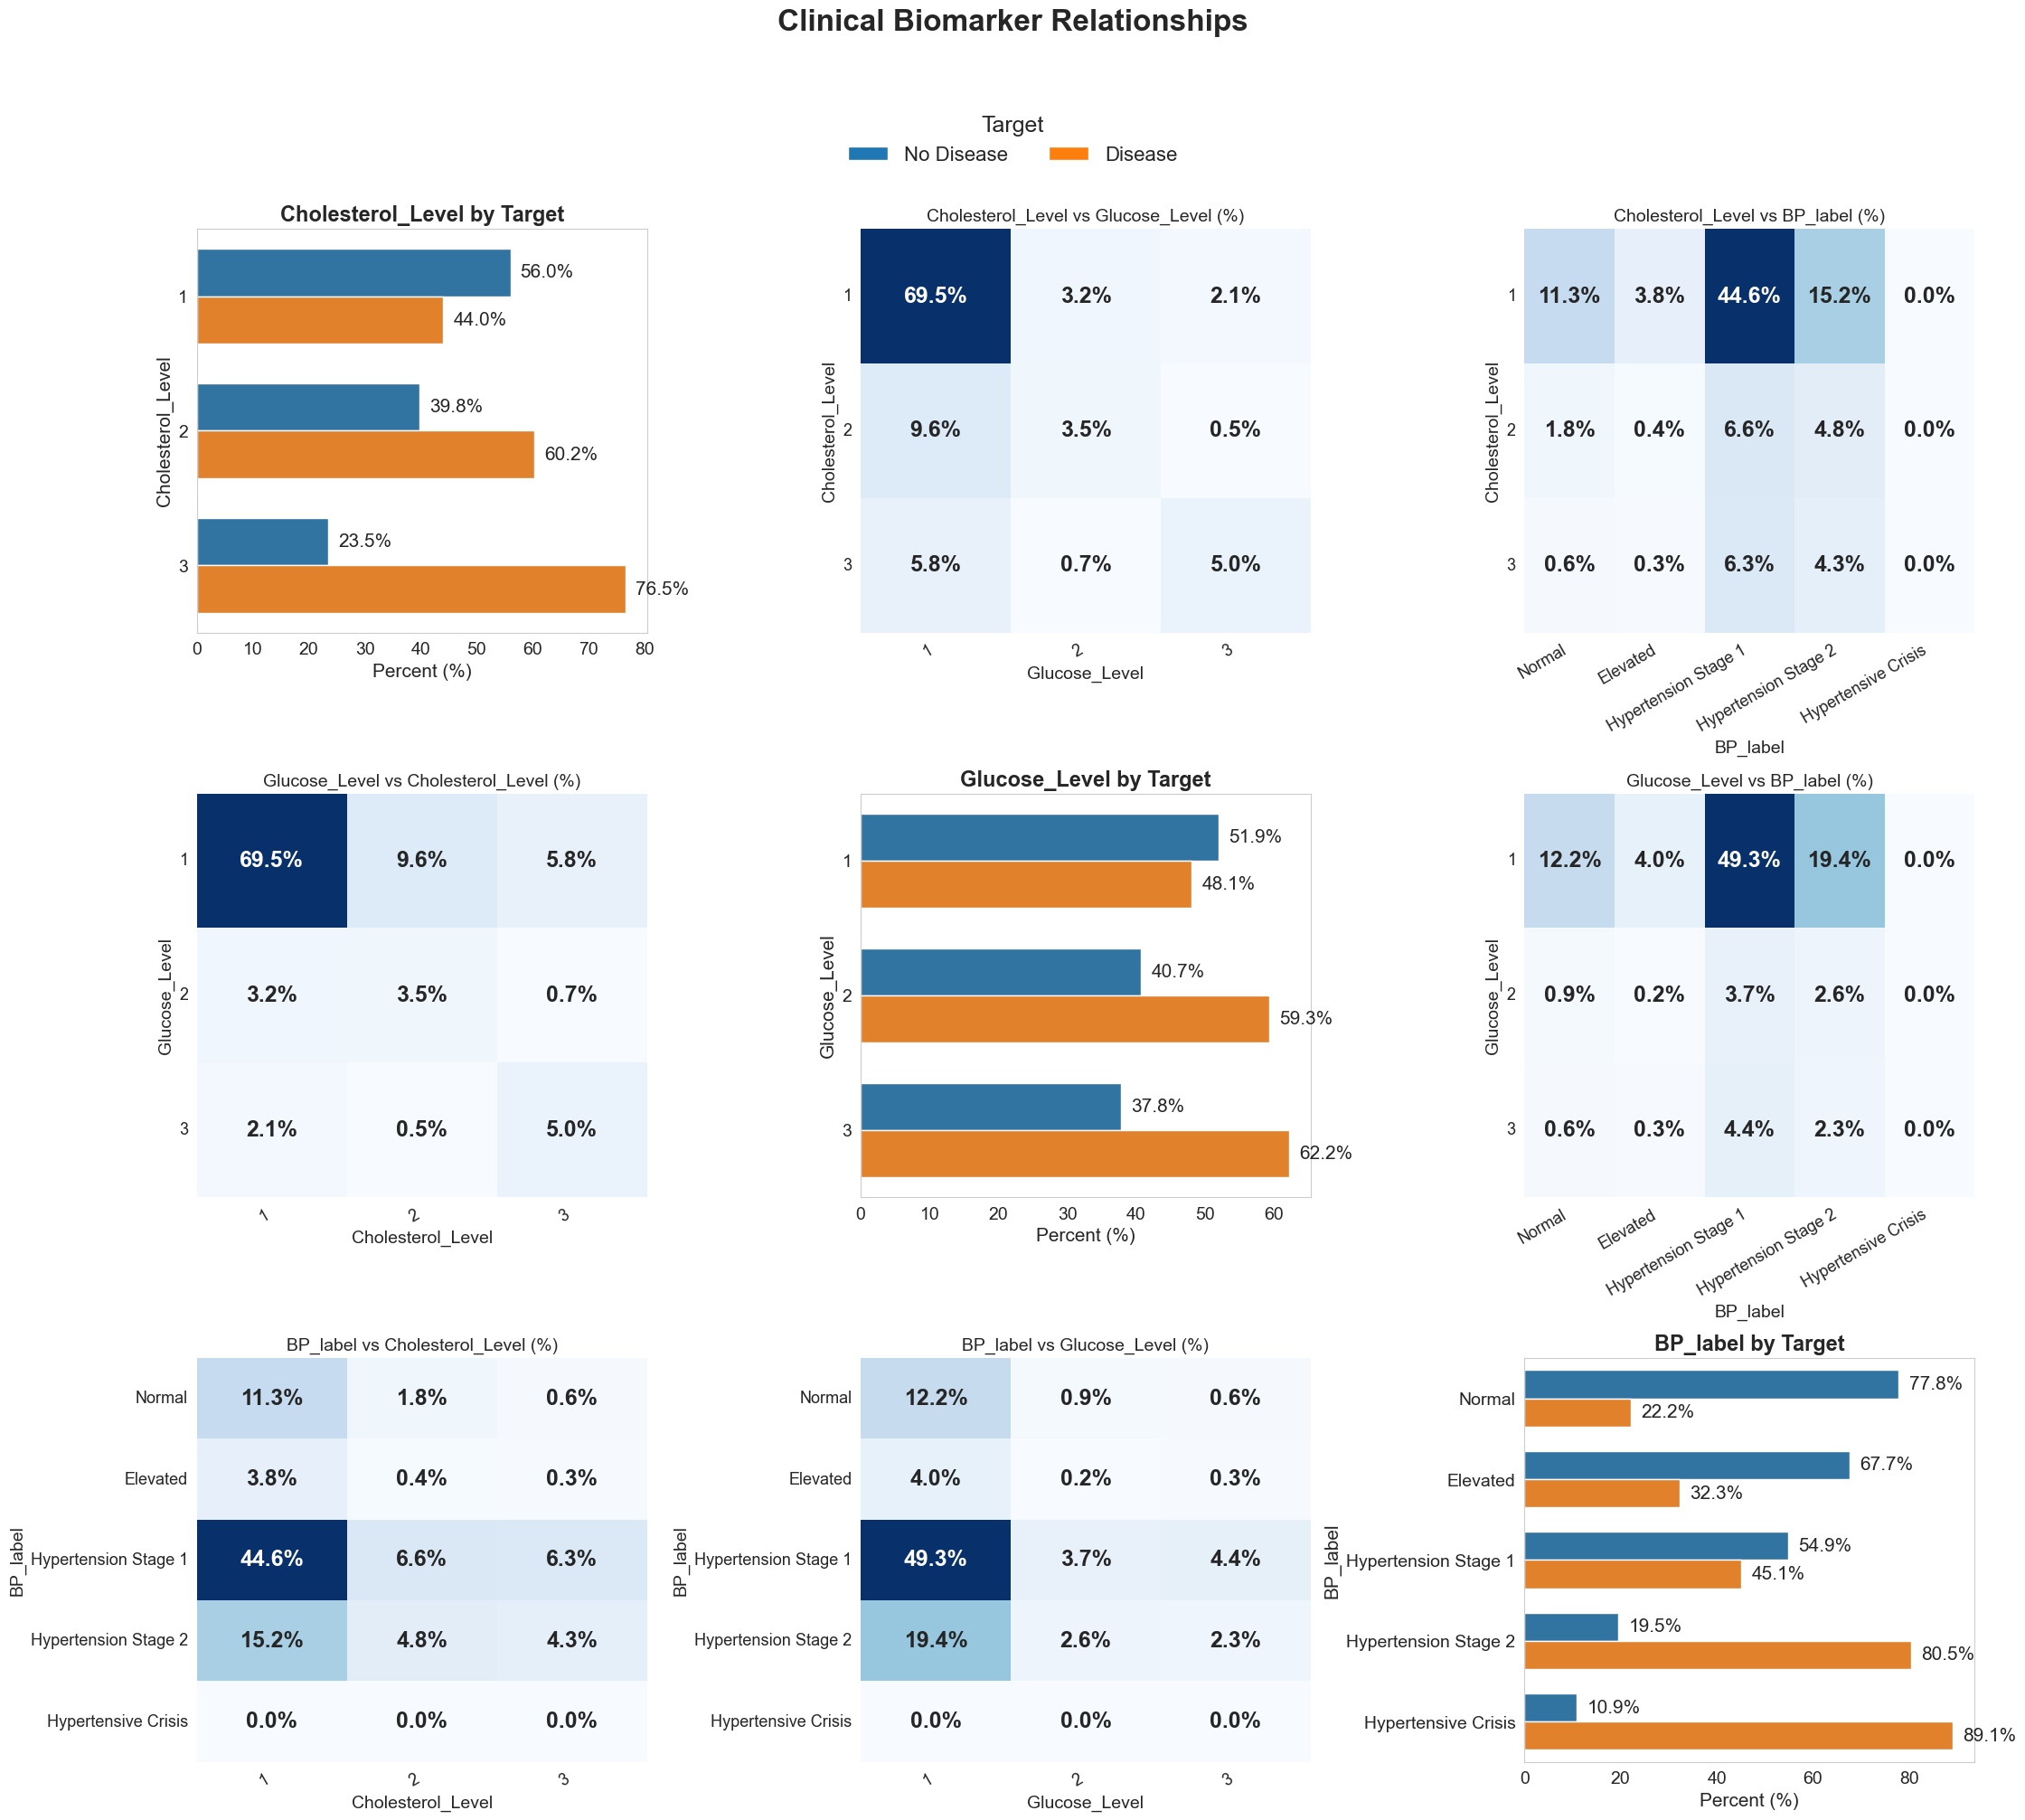

[SUCCESS] Plot saved (overwritten if existed) to: P:\projects\heart disease prediction\reports\visualizations\univariate analysis\categorical analysis\03_Clinical_Biomarkers_Relationships.png


In [22]:
# ---------------------------
# Clinical categorical features
# ---------------------------
clinical_biomarkers = ['Cholesterol_Level', 'Glucose_Level', 'BP_label']

# ---------------------------
# Ensure target_name exists
# ---------------------------
if 'target_name' not in df.columns and 'target' in df.columns:
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

TARGET_PALETTE = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}
target_labels = list(TARGET_PALETTE.keys())
n = len(clinical_biomarkers)

# ---------------------------
# Directory to save plots (create only if missing)
# ---------------------------
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate analysis' / 'categorical analysis'
if not PLOT_DIR.exists():
    PLOT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------
# Figure layout
# ---------------------------
fig, axes = plt.subplots(n, n, figsize=(7.5*n, 6.5*n), squeeze=False)

# ---------------------------
# Plotting
# ---------------------------
for i, row_feat in enumerate(clinical_biomarkers):
    for j, col_feat in enumerate(clinical_biomarkers):
        ax = axes[i, j]
        if i == j:
            # Diagonal: Grouped barplot by target (% labels)
            ct = pd.crosstab(df[row_feat], df['target_name'])
            ct = ct.loc[ct.sum(axis=1) > 0]  # Remove empty rows
            ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
            ct_pct = ct_pct.reset_index().melt(
                id_vars=row_feat, var_name='target_name', value_name='percent'
            )
            
            sns.barplot(
                data=ct_pct, y=row_feat, x='percent', hue='target_name',
                palette=TARGET_PALETTE, ax=ax, dodge=True, width=0.7,
                orient='h', legend=False
            )
            for c in ax.containers:
                ax.bar_label(c, fmt='%.1f%%', fontsize=15, padding=8, label_type='edge')
            
            ax.set_ylabel(row_feat, fontsize=15)
            ax.set_xlabel('Percent (%)', fontsize=15)
            ax.set_title(f'{row_feat} by Target', fontsize=17, weight='bold')
            ax.grid(False)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=14)
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
        else:
            # Off-diagonal: Heatmap of joint distribution (% of total)
            ct = pd.crosstab(df[row_feat], df[col_feat])
            ct = ct.loc[ct.sum(axis=1) > 0, ct.sum(axis=0) > 0]  # Remove empty bins
            if ct.shape[0] > 0 and ct.shape[1] > 0:
                ct_pct = ct / ct.values.sum() * 100
                hm = sns.heatmap(
                    ct_pct, annot=True, fmt='.1f', cmap='Blues', cbar=False, ax=ax,
                    annot_kws={"fontsize": 18, "fontweight": "bold"}
                )
                for text in hm.texts:
                    text.set_text(f"{text.get_text()}%")
                ax.set_xlabel(col_feat, fontsize=14)
                ax.set_ylabel(row_feat, fontsize=14)
                ax.set_title(f'{row_feat} vs {col_feat} (%)', fontsize=14)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=13)
                ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=13)
            else:
                ax.axis('off')

# ---------------------------
# Main title and legend
# ---------------------------
fig.suptitle('Clinical Biomarker Relationships', fontsize=24, weight='bold', y=1.03)
handles = [Patch(facecolor=TARGET_PALETTE[name], label=name) for name in target_labels]
fig.legend(
    handles=handles, labels=target_labels, title='Target', title_fontsize=18, fontsize=16,
    loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=len(target_labels), frameon=False
)

plt.tight_layout(rect=(0, 0, 1, 0.95))

# ---------------------------
# Save figure (overwrite if exists)
# ---------------------------
img_path = PLOT_DIR / '03_Clinical_Biomarkers_Relationships.png'
try:
    plt.savefig(img_path, bbox_inches='tight', dpi=150)  # overwrite directly
    plt.show()
    print(f"[SUCCESS] Plot saved (overwritten if existed) to: {img_path.resolve()}")
except Exception as e:
    print(f"[ERROR] Could not save plot: {e}")

# ---------------------------
# Cleanup
# ---------------------------
df.drop(['target_name'], axis=1, inplace=True, errors='ignore')

### **Observations**

* **Blood Pressure:**
    * **Disease Risk:** Higher blood pressure is strongly linked to the disease. The disease rate is **over 3 times higher** for those in hypertensive crisis (69.1%) compared to those with normal BP (22.2%).
    * **Population Habits:** The heatmaps show that **Hypertension Stage 1** is the most common condition in this dataset. It frequently occurs with normal cholesterol levels (in 44.6% of people) and normal glucose levels (in 49.3% of people).

* **Cholesterol:**
    * **Disease Risk:** This is a major risk factor. The chance of disease **nearly doubles**, rising from 44.0% in the lowest cholesterol group to 76.5% in the highest.
    * **Population Habits:** The heatmaps reveal that the most common profile is having **normal cholesterol (Level 1) while also having Hypertension Stage 1**. This combination describes a large portion of the population (44.6%).

* **Glucose:**
    * **Disease Risk:** High blood sugar is a clear warning sign. The disease rate shows a **significant increase**, rising from 48.1% in the lowest glucose group to 62.2% in the highest.
    * **Population Habits:** Similar to cholesterol, the most frequent combination is having **normal glucose levels (Level 1) alongside Hypertension Stage 1**, which accounts for nearly half the people in the dataset (49.3%).

In [23]:
clinical_biomarkers = ['Cholesterol_Level', 'Glucose_Level', 'BP_label']
target_col = 'target'

category_orders = {
    'Cholesterol_Level': ['Normal', 'Above Normal', 'Well Above Normal'],
    'Glucose_Level': ['Normal', 'Above Normal', 'Well Above Normal'],
    'BP_label': ['Normal', 'Elevated', 'Hypertension Stage 1', 'Hypertension Stage 2', 'Hypertensive Crisis']
}

# --- Map integer codes to string labels for Cholesterol_Level and Glucose_Level ---
chol_map = {1: 'Normal', 2: 'Above Normal', 3: 'Well Above Normal'}
gluc_map = {1: 'Normal', 2: 'Above Normal', 3: 'Well Above Normal'}

if 'Cholesterol_Level' in df.columns and df['Cholesterol_Level'].dtype != 'O':
    df['Cholesterol_Level'] = df['Cholesterol_Level'].map(chol_map)
if 'Glucose_Level' in df.columns and df['Glucose_Level'].dtype != 'O':
    df['Glucose_Level'] = df['Glucose_Level'].map(gluc_map)

# --- Ensure columns are categorical with correct order ---
from pandas.api.types import CategoricalDtype
for col, order in category_orders.items():
    if col in df.columns:
        if not isinstance(df[col].dtype, CategoricalDtype) or list(df[col].cat.categories) != order:
            df[col] = pd.Categorical(df[col], categories=order, ordered=True)

results = []
for col in clinical_biomarkers:
    if col not in df.columns:
        print(f"Skipping '{col}' because it is not in the DataFrame.")
        continue
    # Drop rows where col or target_col is missing
    valid = df[[col, target_col]].dropna()
    if valid.empty:
        print(f"Skipping '{col}' due to all values missing after dropna.")
        continue
    ct = pd.crosstab(valid[col], valid[target_col])
    if ct.empty:
        print(f"Skipping '{col}' due to no data, resulting in an empty crosstab.")
        continue

    chi2, p, dof, expected = chi2_contingency(ct)
    n = ct.values.sum()
    phi2 = chi2 / n
    r, k = ct.shape
    cramers_v = (phi2 / min(k - 1, r - 1)) ** 0.5 if min(k - 1, r - 1) > 0 else 0

    direction = None
    if 1 in ct.columns:
        rates = ct.div(ct.sum(axis=1), axis=0)[1]
        # Only compare if both first and last are not nan
        if not rates.empty and len(rates) > 1 and not (pd.isna(rates.iloc[0]) or pd.isna(rates.iloc[-1])):
            if rates.iloc[-1] > rates.iloc[0]:
                direction = "positive"
            elif rates.iloc[-1] < rates.iloc[0]:
                direction = "negative"
            else:
                direction = "equal"

    results.append({
        "Feature": col,
        "Chi2_p": p,
        "CramersV": cramers_v,
        "Direction": direction
    })

results_df = pd.DataFrame(results)
results_df = results_df[["Feature", "Chi2_p", "CramersV", "Direction"]]

display(results_df)

,Feature,Chi2_p,CramersV,Direction
0,Cholesterol_Level,0.000000e+00,0.221120,positive
1,Glucose_Level,5.150929e-128,0.091526,positive
2,BP_label,0.000000e+00,0.379670,positive


### ***Observations:***

*  **Blood Pressure: The Strongest Warning Sign**
    This is the **most important predictor** of the three. The link is very clear and strong. The risk of having the disease skyrockets from **22%** in the 'Normal' blood pressure group to **89%** in the 'Hypertensive Crisis' group.

*  **Cholesterol: A Moderate Risk Factor**
    Higher cholesterol is also a significant factor, though not as strong as blood pressure. The disease rate rises from **56%** for people with the lowest cholesterol level to over **78%** for those with the highest level.

*  **Glucose: The Weakest Link**
    While still a factor, high glucose has the **weakest connection** to the disease among these three. The risk increases more modestly, from **48%** at the lowest level to **62%** at the highest.

### -> Demographics

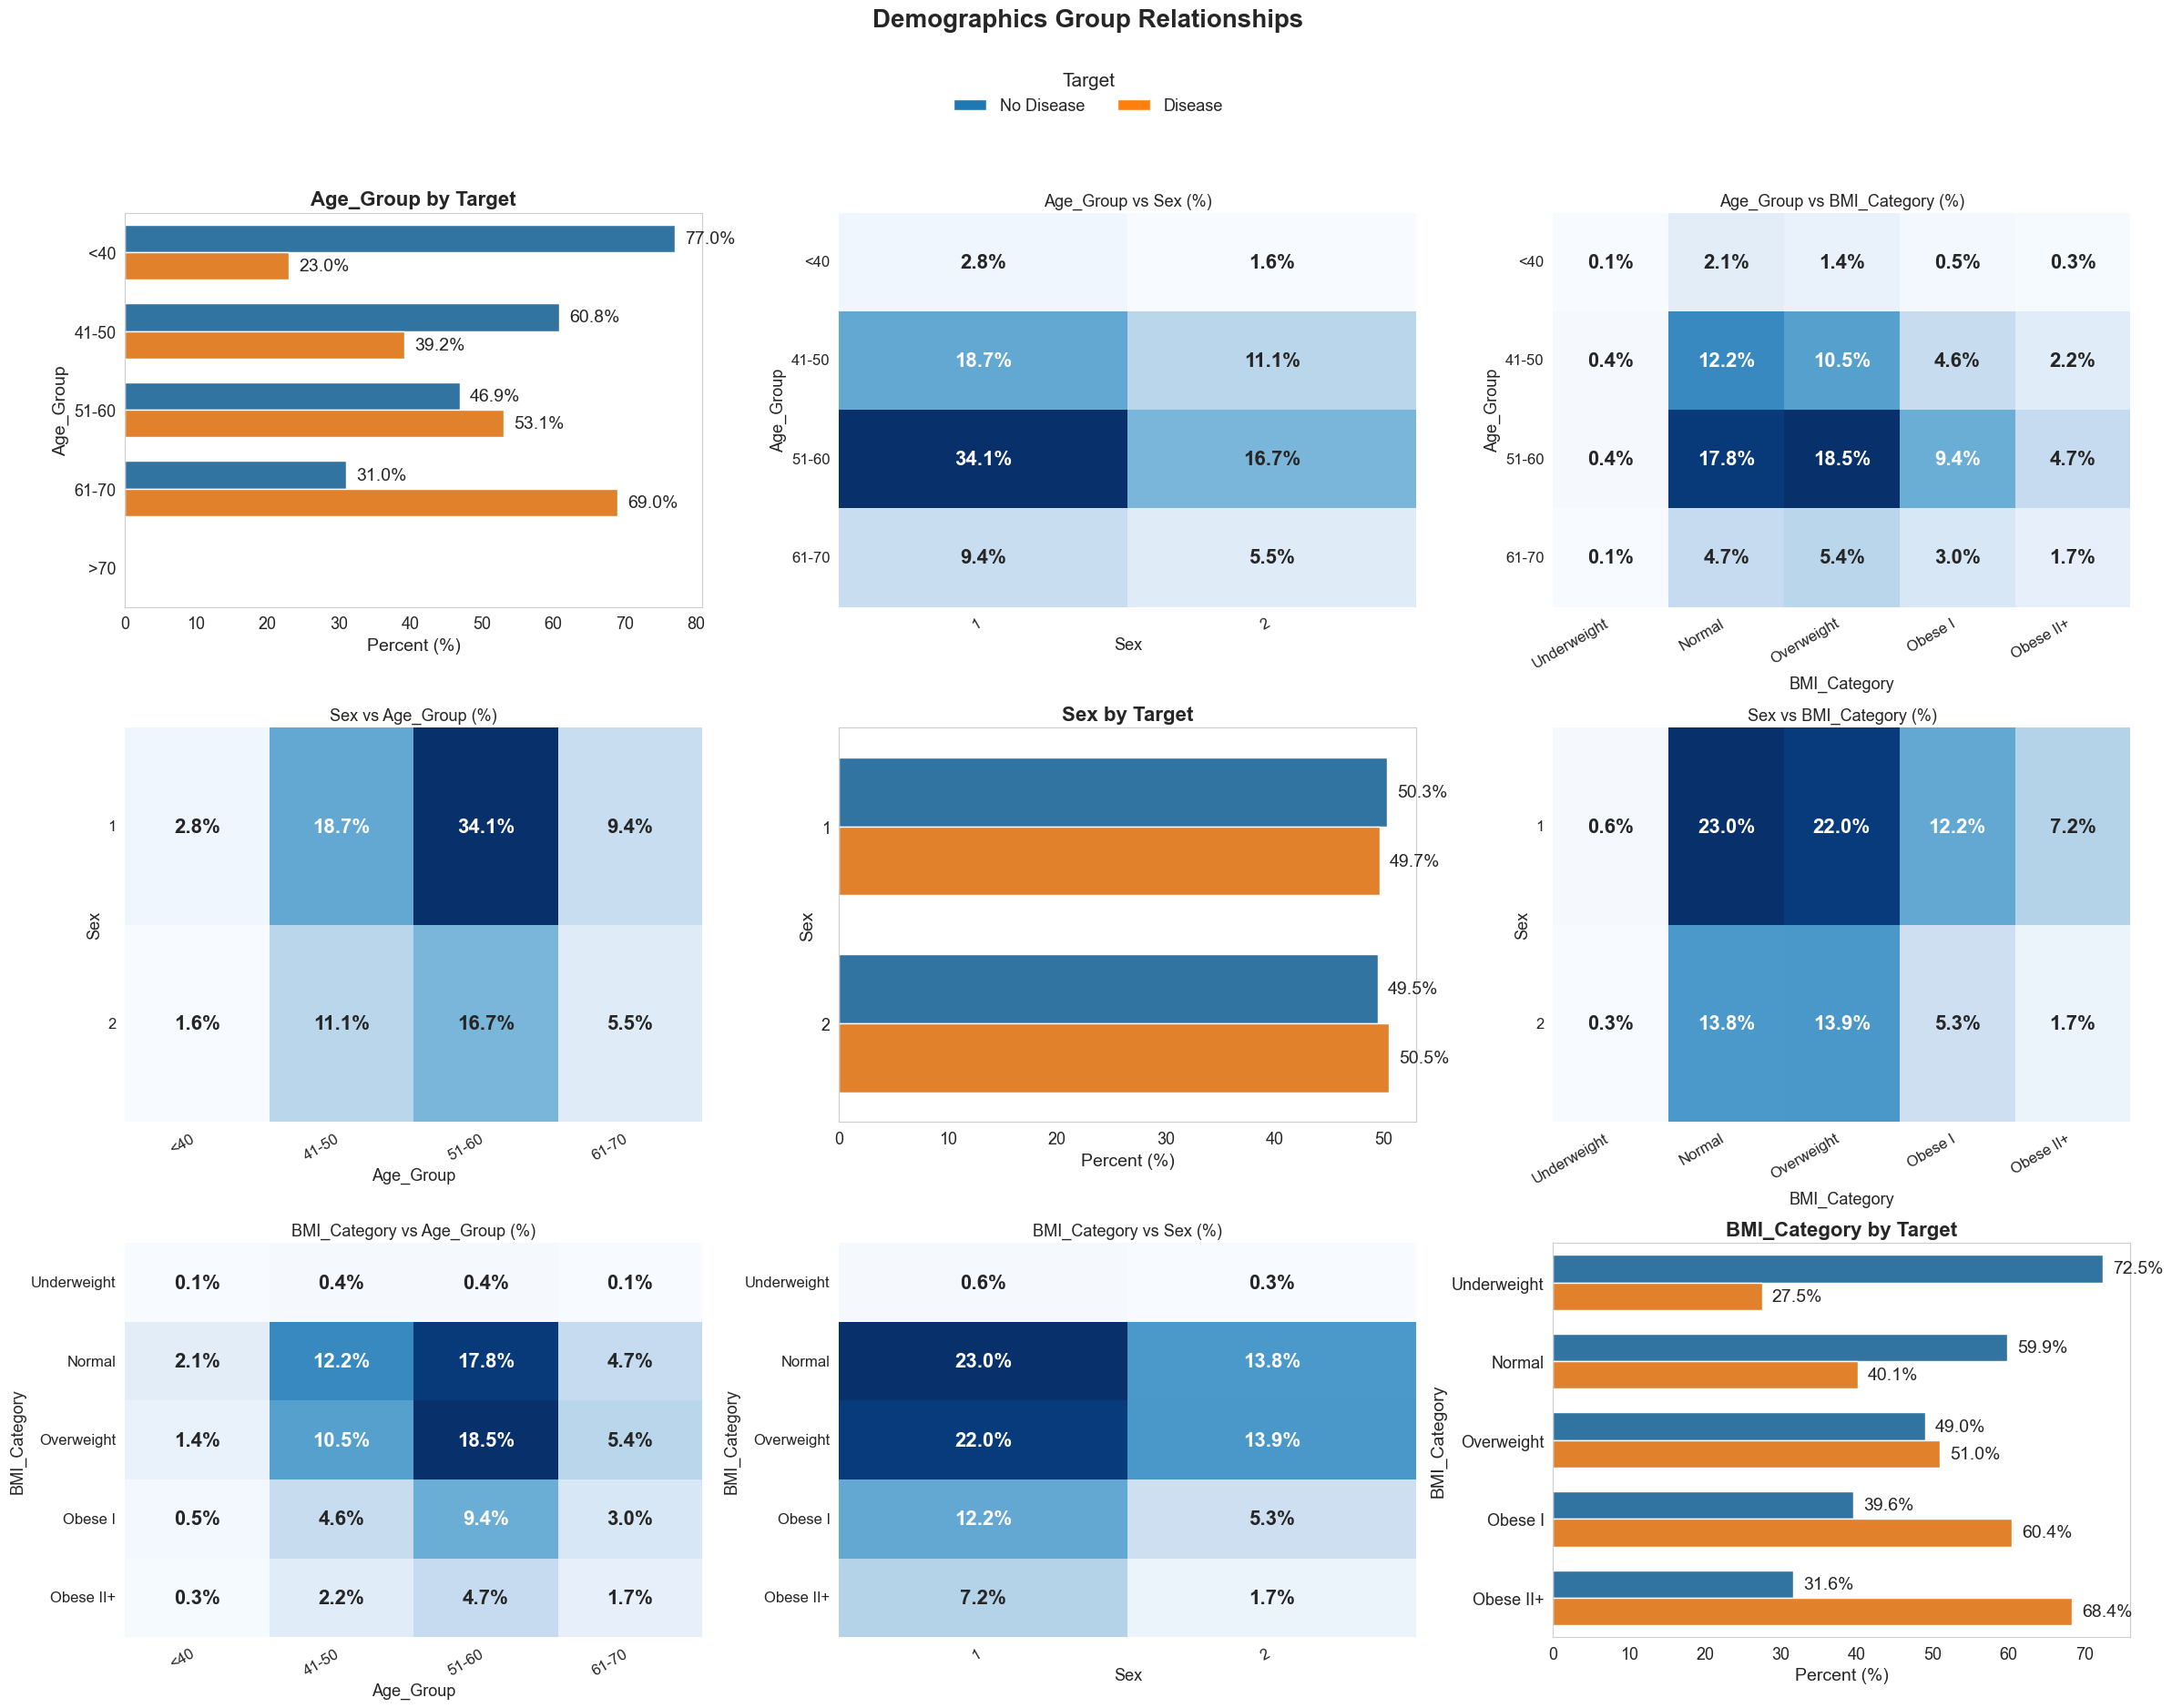

[SUCCESS] Plot saved (overwritten if existed) to: P:\projects\heart disease prediction\reports\visualizations\univariate analysis\categorical analysis\04_Demographics_Group_Relationships.png


In [24]:
# ---------------------------
# Demographic features
# ---------------------------
demographics = ['Age_Group', 'Sex', 'BMI_Category']

# ---------------------------
# Ensure target_name exists
# ---------------------------
if 'target_name' not in df.columns and 'target' in df.columns:
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

TARGET_PALETTE = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}
target_labels = list(TARGET_PALETTE.keys())
n = len(demographics)

# ---------------------------
# Directory to save plots (create only if missing)
# ---------------------------
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate analysis' / 'categorical analysis'
if not PLOT_DIR.exists():
    PLOT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------
# Figure layout
# ---------------------------
fig, axes = plt.subplots(n, n, figsize=(8*n, 6*n), squeeze=False)

# ---------------------------
# Plotting
# ---------------------------
for i, row_feat in enumerate(demographics):
    for j, col_feat in enumerate(demographics):
        ax = axes[i, j]
        if i == j:
            # Diagonal: Grouped barplot by target (% labels)
            ct = pd.crosstab(df[row_feat], df['target_name'])
            ct = ct.loc[ct.sum(axis=1) > 0]  # remove empty rows
            ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
            ct_pct = ct_pct.reset_index().melt(
                id_vars=row_feat, var_name='target_name', value_name='percent'
            )

            sns.barplot(
                data=ct_pct, y=row_feat, x='percent', hue='target_name',
                palette=TARGET_PALETTE, ax=ax, dodge=True, width=0.7,
                orient='h', legend=False
            )
            for c in ax.containers:
                ax.bar_label(c, fmt='%.1f%%', fontsize=14, padding=8, label_type='edge')

            ax.set_ylabel(row_feat, fontsize=14)
            ax.set_xlabel('Percent (%)', fontsize=14)
            ax.set_title(f'{row_feat} by Target', fontsize=16, weight='bold')
            ax.grid(False)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=13)
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)

        else:
            # Off-diagonal: Heatmap of joint distribution (% of total)
            ct = pd.crosstab(df[row_feat], df[col_feat])
            ct = ct.loc[ct.sum(axis=1) > 0, ct.sum(axis=0) > 0]  # remove empty bins
            if ct.shape[0] > 0 and ct.shape[1] > 0:
                ct_pct = ct / ct.values.sum() * 100
                hm = sns.heatmap(
                    ct_pct, annot=True, fmt='.1f', cmap='Blues', cbar=False, ax=ax,
                    annot_kws={"fontsize": 16, "fontweight": "bold"}
                )
                for text in hm.texts:
                    text.set_text(f"{text.get_text()}%")
                ax.set_xlabel(col_feat, fontsize=13)
                ax.set_ylabel(row_feat, fontsize=13)
                ax.set_title(f'{row_feat} vs {col_feat} (%)', fontsize=13)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=12)
                ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
            else:
                ax.axis('off')

# ---------------------------
# Main title and legend
# ---------------------------
fig.suptitle('Demographics Group Relationships', fontsize=20, weight='bold', y=1.04)
handles = [Patch(facecolor=TARGET_PALETTE[name], label=name) for name in target_labels]
fig.legend(
    handles=handles, labels=target_labels, title='Target', title_fontsize=15, fontsize=13,
    loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=len(target_labels), frameon=False
)

plt.tight_layout(rect=(0, 0, 1, 0.96))

# ---------------------------
# Save figure (overwrite if exists)
# ---------------------------
img_path = PLOT_DIR / '04_Demographics_Group_Relationships.png'
try:
    plt.savefig(img_path, bbox_inches='tight', dpi=150)  # overwrite directly
    plt.show()
    print(f"[SUCCESS] Plot saved (overwritten if existed) to: {img_path.resolve()}")
except Exception as e:
    print(f"[ERROR] Could not save plot: {e}")

# ---------------------------
# Cleanup
# ---------------------------
df.drop(['target_name'], axis=1, inplace=True, errors='ignore')

***Observations:***

* **Age Group:**
    * **Disease Risk:** Age is a huge factor. The chance of having the disease **triples**, rising from 23.0% in the youngest group (`<40`) to 69.0% in the oldest group (`61-70`).
    * **Population Habits:** The heatmaps show the study population is heavily concentrated in the **'51-60' age bracket**. The single largest demographic is Sex '1' within this age group (34.1%).

* **BMI Category:**
    * **Disease Risk:** Higher BMI is strongly linked to higher disease risk, which increases from 40.1% for 'Normal' to 68.4% for 'Obese II+'. Surprisingly, the **'Underweight' group has the highest disease rate** of all at 72.5%.
    * **Population Habits:** The most common profile is an individual in their 50s with a **'Normal' (17.8%) or 'Overweight' (18.5%) BMI**.

* **Sex:**
    * **Disease Risk:** Sex **does not make a significant difference**. The disease rate is almost exactly 50/50 for both groups.
    * **Population Habits:** The heatmaps show that the study population is not evenly split by sex within age groups. For example, the large **'51-60' age group** is predominantly composed of individuals from Sex '1' (34.1%) over Sex '2' (16.7%).

In [25]:
# Ensure correct columns exist and are not mislabelled
expected_demographics = ['Age_Group', 'Sex', 'BMI_Category']
for col in expected_demographics:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in DataFrame. Check column names and feature engineering steps.")

# Ensure correct dtype for each demographic variable
if not pd.api.types.is_categorical_dtype(df['Age_Group']):
    df['Age_Group'] = df['Age_Group'].astype('category')
if not pd.api.types.is_categorical_dtype(df['BMI_Category']):
    df['BMI_Category'] = df['BMI_Category'].astype('category')
if not pd.api.types.is_categorical_dtype(df['Sex']):
    df['Sex'] = df['Sex'].astype('category')

demographics = ['Age_Group', 'Sex', 'BMI_Category']
target_col = 'target'

results = []
for col in demographics:
    ct = pd.crosstab(df[col], df[target_col])
    if ct.empty:
        print(f"Skipping '{col}' due to no data, resulting in an empty crosstab.")
        continue
    chi2, p, dof, expected = chi2_contingency(ct)
    n = ct.values.sum()
    phi2 = chi2 / n
    r, k = ct.shape
    cramers_v = (phi2 / min(k - 1, r - 1)) ** 0.5 if min(k - 1, r - 1) > 0 else 0
    # Direction: difference in disease rate between highest and lowest category
    rates = ct.div(ct.sum(axis=1), axis=0)[1] if 1 in ct.columns else None
    direction = None
    if rates is not None and len(rates) > 1:
        if not (pd.isna(rates.iloc[0]) or pd.isna(rates.iloc[-1])):
            if rates.iloc[-1] > rates.iloc[0]:
                direction = "positive"
            elif rates.iloc[-1] < rates.iloc[0]:
                direction = "negative"
            else:
                direction = "equal"
    results.append({
        "Feature": col,
        "Chi2_p": p,
        "CramersV": cramers_v,
        "Direction": direction
    })

results_df = pd.DataFrame(results)
results_df = results_df[["Feature", "Chi2_p", "CramersV", "Direction"]]
display(results_df)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8688\1600276651.py:8: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df['Age_Group']):
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8688\1600276651.py:10: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df['BMI_Category']):
C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8688\1600276651.py:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df['Sex']):


,Feature,Chi2_p,CramersV,Direction
0,Age_Group,0.000000,0.224825,positive
1,Sex,0.034164,0.008007,positive
2,BMI_Category,0.000000,0.189575,positive


### ***Observations:***

* **Age: The Strongest Factor**
    **Age is the most important demographic predictor.** The risk of having the disease increases significantly as people get older. The chance of disease starts at just **23%** for those under 40 and climbs to **69%** for the 61-70 age group.

*  **BMI: Also a Strong Factor**
    **Body Mass Index (BMI) is another very strong risk factor.** A higher BMI is clearly linked to a higher disease risk. The risk goes from **27.5%** for the 'Underweight' category up to **68%** for the most obese category.

*  **Sex: Not a Significant Factor**
    **Sex has a very weak and practically irrelevant link** to the disease. The disease rates are nearly identical for both sexes, hovering around **50%**.

### -> Lifestyle

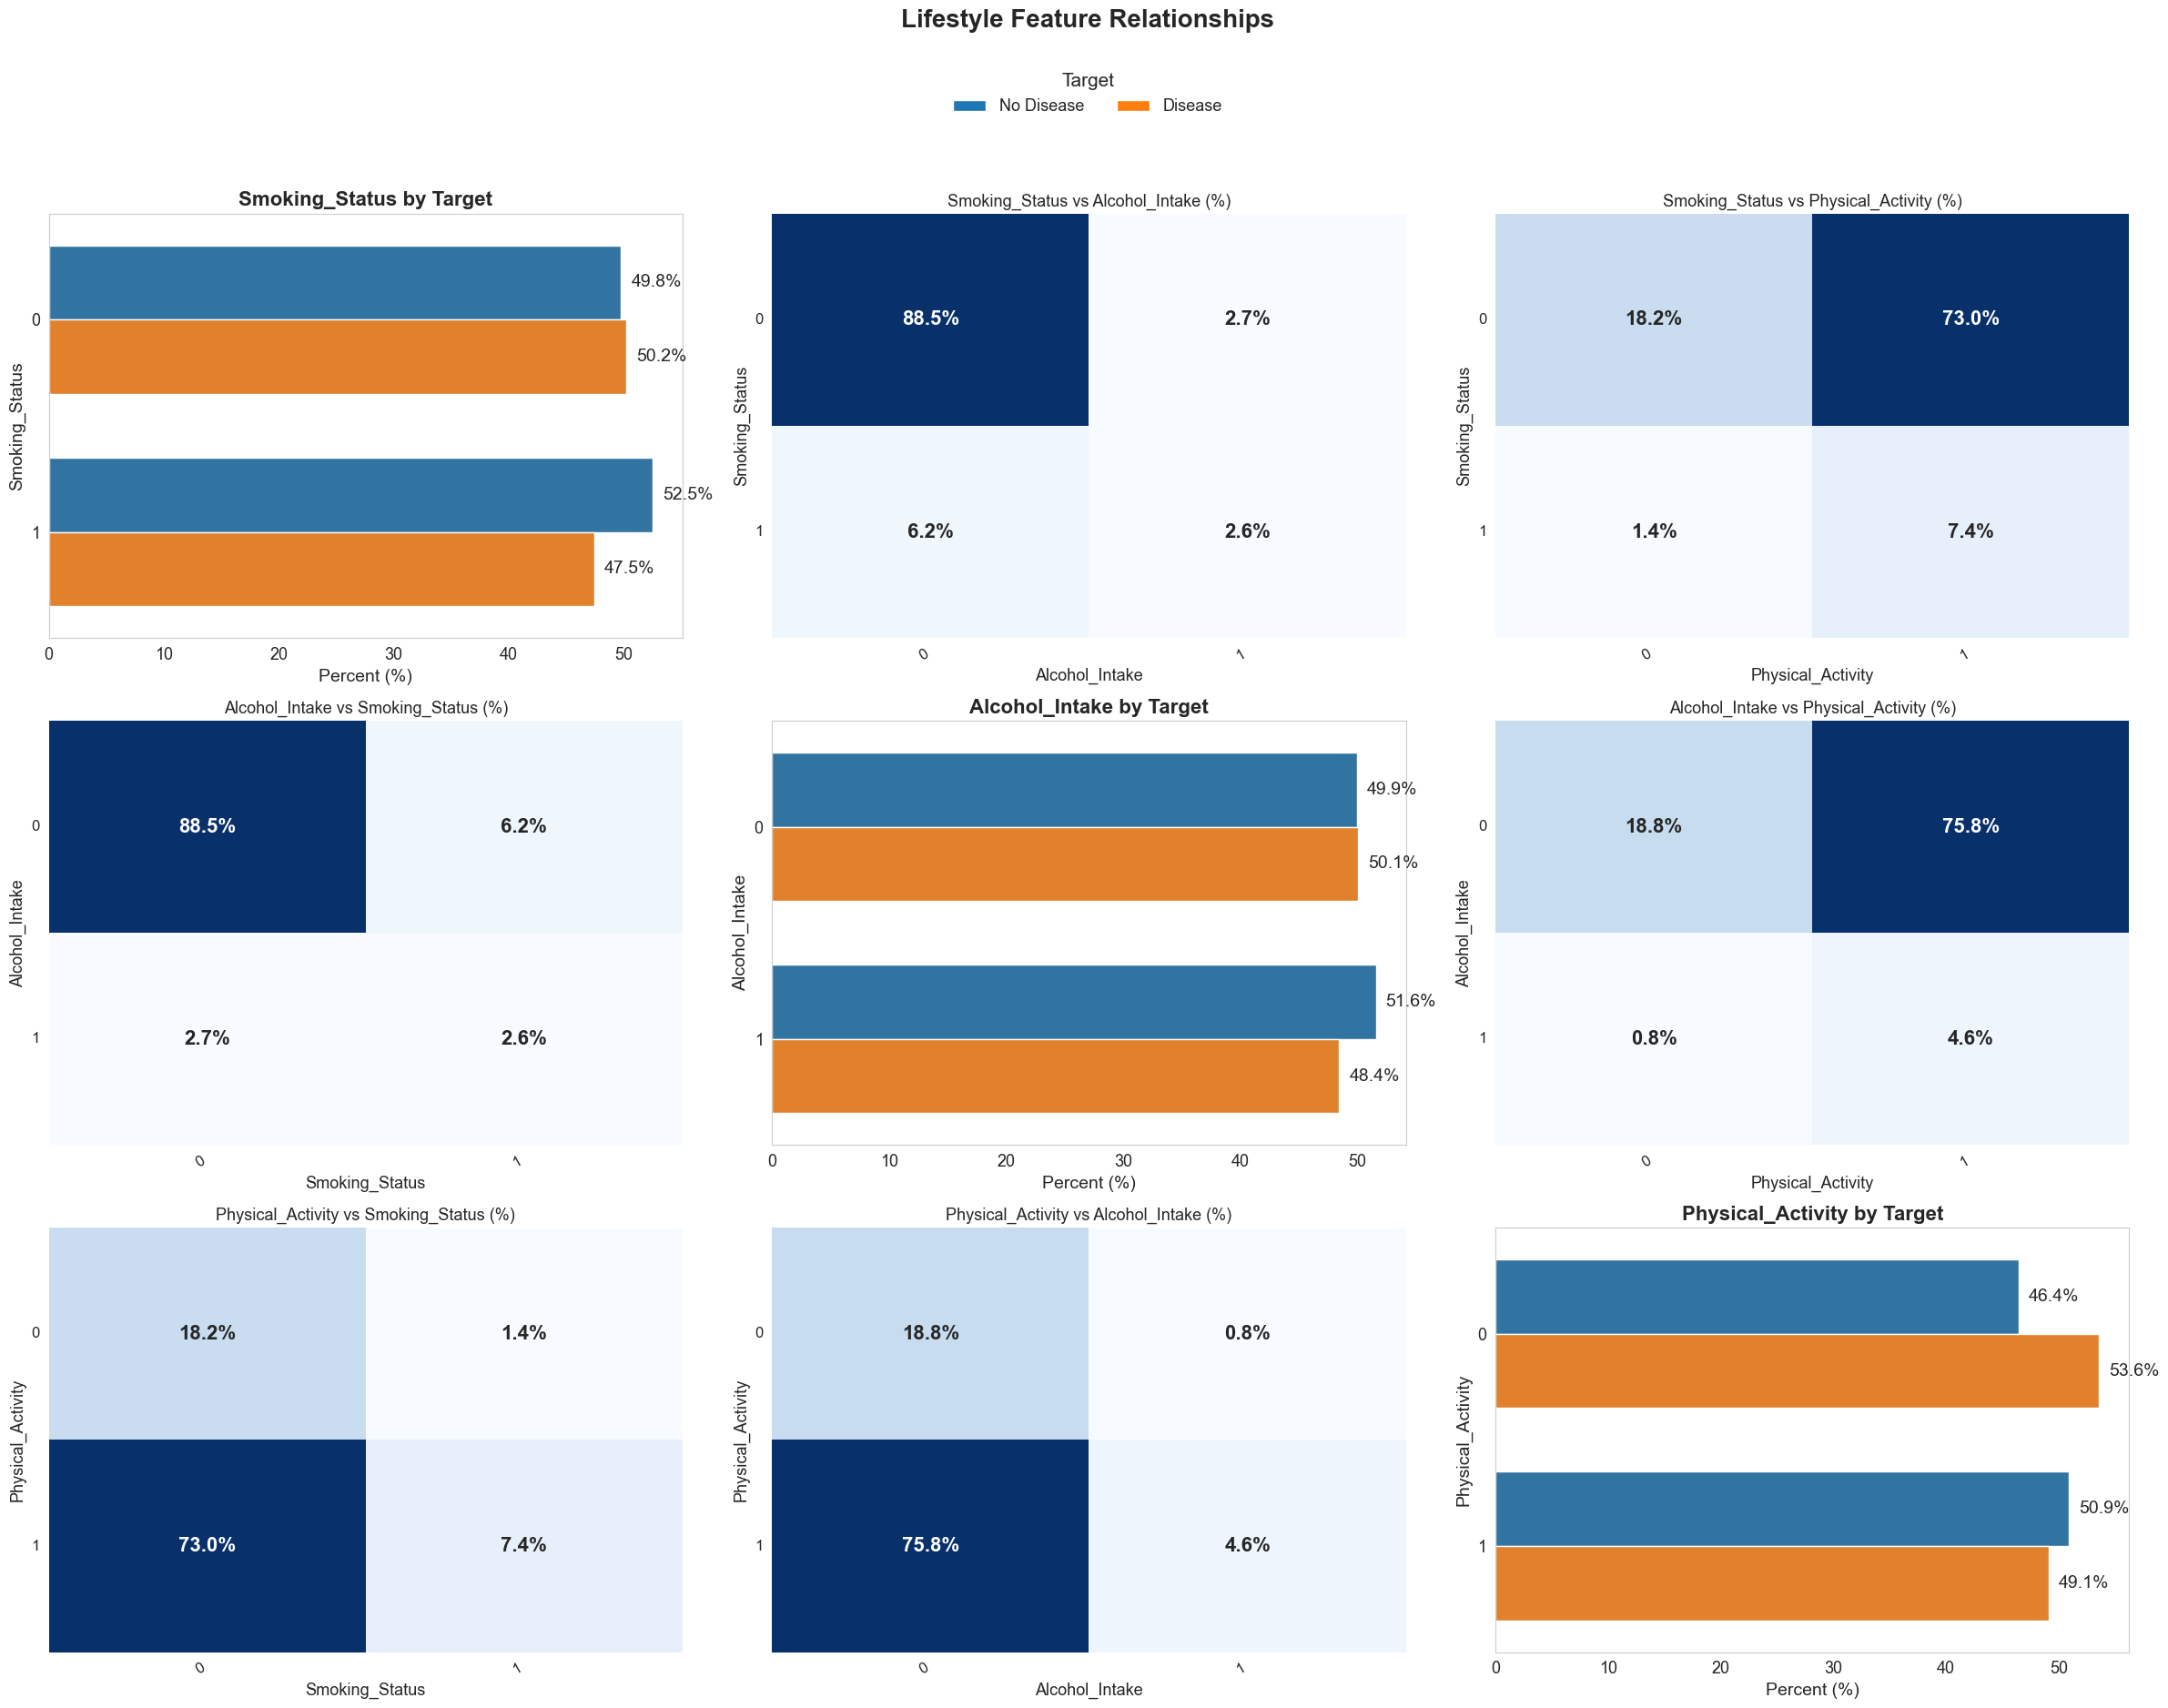

[SUCCESS] Plot saved (overwritten if existed) to: P:\projects\heart disease prediction\reports\visualizations\univariate analysis\categorical analysis\03_Lifestyle_Feature_Relationships.png


In [26]:
# ---------------------------
# Lifestyle features
# ---------------------------
lifestyle = ['Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']

# ---------------------------
# Ensure target_name exists
# ---------------------------
if 'target_name' not in df.columns and 'target' in df.columns:
    df['target_name'] = df['target'].map({0: 'No Disease', 1: 'Disease'})

TARGET_PALETTE = {'No Disease': '#1f77b4', 'Disease': '#ff7f0e'}
target_labels = list(TARGET_PALETTE.keys())
n = len(lifestyle)

# ---------------------------
# Directory to save plots
# ---------------------------
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'univariate analysis' / 'categorical analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)

# ---------------------------
# Figure layout
# ---------------------------
fig, axes = plt.subplots(n, n, figsize=(8*n, 6*n), squeeze=False)

# ---------------------------
# Plotting
# ---------------------------
for i, row_feat in enumerate(lifestyle):
    for j, col_feat in enumerate(lifestyle):
        ax = axes[i, j]
        if i == j:
            # Diagonal: Grouped barplot by target (% labels)
            ct = pd.crosstab(df[row_feat], df['target_name'])
            ct = ct.loc[ct.sum(axis=1) > 0]  # remove empty rows
            ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100
            ct_pct = ct_pct.reset_index().melt(id_vars=row_feat, var_name='target_name', value_name='percent')

            sns.barplot(
                data=ct_pct, y=row_feat, x='percent', hue='target_name',
                palette=TARGET_PALETTE, ax=ax, dodge=True, width=0.7, orient='h', legend=False
            )
            for c in ax.containers:
                ax.bar_label(c, fmt='%.1f%%', fontsize=14, padding=8, label_type='edge')

            ax.set_ylabel(row_feat, fontsize=14)
            ax.set_xlabel('Percent (%)', fontsize=14)
            ax.set_title(f'{row_feat} by Target', fontsize=16, weight='bold')
            ax.grid(False)
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=13)
            ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)

        else:
            # Off-diagonal: Heatmap of joint distribution (% of total)
            ct = pd.crosstab(df[row_feat], df[col_feat])
            ct = ct.loc[ct.sum(axis=1) > 0, ct.sum(axis=0) > 0]
            if ct.shape[0] > 0 and ct.shape[1] > 0:
                ct_pct = ct / ct.values.sum() * 100
                hm = sns.heatmap(
                    ct_pct, annot=True, fmt='.1f', cmap='Blues', cbar=False, ax=ax,
                    annot_kws={"fontsize": 16, "fontweight": "bold"}
                )
                for text in hm.texts:
                    text.set_text(f"{text.get_text()}%")
                ax.set_xlabel(col_feat, fontsize=13)
                ax.set_ylabel(row_feat, fontsize=13)
                ax.set_title(f'{row_feat} vs {col_feat} (%)', fontsize=13)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right', fontsize=12)
                ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
            else:
                ax.axis('off')

# ---------------------------
# Main title and legend
# ---------------------------
fig.suptitle('Lifestyle Feature Relationships', fontsize=20, weight='bold', y=1.04)
handles = [Patch(facecolor=TARGET_PALETTE[name], label=name) for name in target_labels]
fig.legend(
    handles=handles, labels=target_labels, title='Target', title_fontsize=15, fontsize=13,
    loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=len(target_labels), frameon=False
)

plt.tight_layout(rect=(0, 0, 1, 0.96))

# ---------------------------
# Save figure robustly (overwrite if exists)
# ---------------------------
img_path = PLOT_DIR / '03_Lifestyle_Feature_Relationships.png'
try:
    if img_path.exists():
        img_path.unlink()  # remove old file
    plt.savefig(img_path, bbox_inches='tight', dpi=150)
    plt.show() 
    print(f"[SUCCESS] Plot saved (overwritten if existed) to: {img_path.resolve()}")
except Exception as e:
    print(f"[ERROR] Could not save plot: {e}")

# ---------------------------
# Cleanup
# ---------------------------
df.drop(['target_name'], axis=1, inplace=True, errors='ignore')

#### **1. Smoking Status**
* **Disease Risk:** Smoking status **doesn't seem to matter** for disease risk. The chances are about 50/50 for both groups.
* **Population Habits:** The heatmaps show that the vast majority of people are non-smokers. The most common profile is a **non-smoker who is physically active (73%)**.

#### **2. Alcohol Intake**
* **Disease Risk:** Similar to smoking, alcohol intake shows **no real link** to the disease. The risk is about 50/50 whether a person drinks or not.
* **Population Habits:** The heatmaps reveal that most people are non-drinkers. In fact, nearly 9 out of 10 people (**88.5%**) are in the same **non-smoking, non-drinking** category.

#### **3. Physical Activity**
* **Disease Risk:** This is the only factor that makes a small difference. One activity group (likely the less active one) has a **slightly higher disease risk (54%)** than the other (49%).
* **Population Habits:** The heatmaps show that the most common person in this dataset is **physically active**, with over 75% of non-drinkers also being physically active.

In [27]:
# Ensure correct columns exist and are not mislabelled
expected_lifestyle = ['Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']
for col in expected_lifestyle:
    if col not in df.columns:
        raise ValueError(f"Column '{col}' not found in DataFrame. Check column names and feature engineering steps.")

# Ensure correct dtype for each lifestyle variable
for col in expected_lifestyle:
    if not pd.api.types.is_categorical_dtype(df[col]):
        df[col] = df[col].astype('category')

lifestyle = ['Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']
target_col = 'target'

results = []
for col in lifestyle:
    ct = pd.crosstab(df[col], df[target_col])
    if ct.empty:
        print(f"Skipping '{col}' due to no data, resulting in an empty crosstab.")
        continue
    chi2, p, dof, expected = chi2_contingency(ct)
    n = ct.values.sum()
    phi2 = chi2 / n
    r, k = ct.shape
    cramers_v = (phi2 / min(k - 1, r - 1)) ** 0.5 if min(k - 1, r - 1) > 0 else 0
    # Direction: difference in disease rate between highest and lowest category
    rates = ct.div(ct.sum(axis=1), axis=0)[1] if 1 in ct.columns else None
    direction = None
    if rates is not None and len(rates) > 1:
        if not (pd.isna(rates.iloc[0]) or pd.isna(rates.iloc[-1])):
            if rates.iloc[-1] > rates.iloc[0]:
                direction = "positive"
            elif rates.iloc[-1] < rates.iloc[0]:
                direction = "negative"
            else:
                direction = "equal"
    results.append({
        "Feature": col,
        "Chi2_p": p,
        "CramersV": cramers_v,
        "Direction": direction
    })

results_df = pd.DataFrame(results)
results_df = results_df[["Feature", "Chi2_p", "CramersV", "Direction"]]
display(results_df)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8688\1898225904.py:9: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df[col]):


,Feature,Chi2_p,CramersV,Direction
0,Smoking_Status,4.209577e-05,0.015483,negative
1,Alcohol_Intake,5.340153e-02,0.007302,negative
2,Physical_Activity,4.291420e-21,0.035630,negative


### ***Observations:***

*  ***Physical Activity: A Very Weak Connection ***
    Of these three factors, **Physical Activity** has the strongest link, but it's still **very weak** overall. The data shows that people who are physically active have a slightly lower rate of disease (**49.1%**) compared to those who are not (**53.6%**).

*  **Smoking Status: An Extremely Weak Connection**
    Smoking shows a statistically significant but **practically tiny** relationship with the disease. The difference in disease rates between the two smoking groups is almost negligible (**50.2%** vs. **47.5%**).

* ***Alcohol Intake: No Significant Connection ***
    According to the statistics, **alcohol intake has no significant link** to the disease. The small difference seen in the chart is not statistically meaningful and is likely due to random chance.

### Multivariate Analysis

In [28]:
# Drop unwanted columns with errors='ignore' for robustness
df = df.drop(['Age_Group', 'BMI_Category','BP_label' ], axis=1, errors='ignore')

In [29]:
# ==============================================================================
# 1. IMPORTS & CONFIGURATION
# ==============================================================================
warnings.filterwarnings('ignore')

# --- Configuration ---
N_SPLITS_CV = 5
RANDOM_STATE = 42

# ==============================================================================
# 2. DATA PREPARATION & ADVANCED PREPROCESSING
# ==============================================================================
X = df.drop(columns=['target'])
y = df['target']

# --- Define feature groups by their required encoding type ---
NUMERIC_FEATURES = ['Age_Years', 'BMI', 'Pulse_Pressure']
ORDINAL_FEATURES = [
    'Cholesterol_Level', 'Glucose_Level', 'Smoking_Status',
    'Alcohol_Intake', 'Physical_Activity', 'BP_level'
]
NOMINAL_FEATURES = ['Sex']

# --- Define the specific order for the ordinal features ---
ORDINAL_CATEGORIES = [
    ['Normal', 'Above Normal', 'Well Above Normal'],  # Cholesterol_Level
    ['Normal', 'Above Normal', 'Well Above Normal'],  # Glucose_Level
    [0, 1],                                           # Smoking_Status
    [0, 1],                                           # Alcohol_Intake
    [0, 1],                                           # Physical_Activity
    [1, 2, 3, 4, 5]                                   # BP_level
]

# --- Create the complete preprocessing pipeline ---
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric_scaler', StandardScaler(), NUMERIC_FEATURES),
        ('ordinal_encoder', OrdinalEncoder(categories=ORDINAL_CATEGORIES), ORDINAL_FEATURES),
        ('nominal_encoder', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), NOMINAL_FEATURES)
    ],
    remainder='drop'
)

# --- Split data ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# ==============================================================================
# 3. EARLY STOPPING FUNCTION FOR CV
# ==============================================================================
def early_stopping_cv(pipeline, X, y, n_splits=5, patience=5, min_delta=1e-4, random_state=42):
    """
    Early stopping cross-validation for scikit-learn pipelines.
    Stops if validation ROC AUC does not improve by min_delta for 'patience' rounds.
    Returns the best average ROC AUC and the best fold index.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    best_score = -np.inf
    best_fold = -1
    no_improve = 0
    scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        pipeline.fit(X_train_fold, y_train_fold)
        y_pred_proba = pipeline.predict_proba(X_val_fold)[:, 1]
        score = roc_auc_score(y_val_fold, y_pred_proba)
        scores.append(score)
        if score > best_score + min_delta:
            best_score = score
            best_fold = fold
            no_improve = 0
        else:
            no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at fold {fold+1} (no improvement in {patience} rounds).")
            break
    return np.mean(scores), best_fold

# ==============================================================================
# 4. MODEL TRAINING WITH EARLY STOPPING CV
# ==============================================================================
BALANCERS = {
    'SMOTE': SMOTE(random_state=RANDOM_STATE),
    'RandomOverSampler': RandomOverSampler(random_state=RANDOM_STATE),
    'SMOTEENN': SMOTEENN(random_state=RANDOM_STATE),
    'SMOTETomek': SMOTETomek(random_state=RANDOM_STATE)
}

# Example: Use SMOTE and L2 penalty (you can loop over balancers/penalties if you want)
balancer_name = 'SMOTE'
penalty = 'l2'
C = 0.01

classifier = LogisticRegression(
    solver='saga', penalty=penalty, C=C, max_iter=1000, random_state=RANDOM_STATE
)
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('balancer', BALANCERS[balancer_name]),
    ('classifier', classifier)
])

mean_auc, best_fold = early_stopping_cv(
    pipeline, X_train, y_train, n_splits=N_SPLITS_CV, patience=3, min_delta=1e-4, random_state=RANDOM_STATE
)
print(f"Mean ROC AUC (CV): {mean_auc:.4f} | Best Fold: {best_fold}")

# ==============================================================================
# 5. FINAL MODEL TRAINING AND COEFFICIENTS
# ==============================================================================
pipeline.fit(X_train, y_train)
final_model = pipeline.named_steps['classifier']
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
coefficients = pd.Series(final_model.coef_[0], index=feature_names)
model_wt = pd.DataFrame({
    'Feature': coefficients.index,
    'Coefficient': coefficients.values
}).sort_values(by='Coefficient', key=abs, ascending=False)

print(f"Best Balancer: {balancer_name}")
print("\n--- Final Model Feature Importance (Coefficients) ---")
print(model_wt.to_string(index=False))

NameError: name 'ColumnTransformer' is not defined

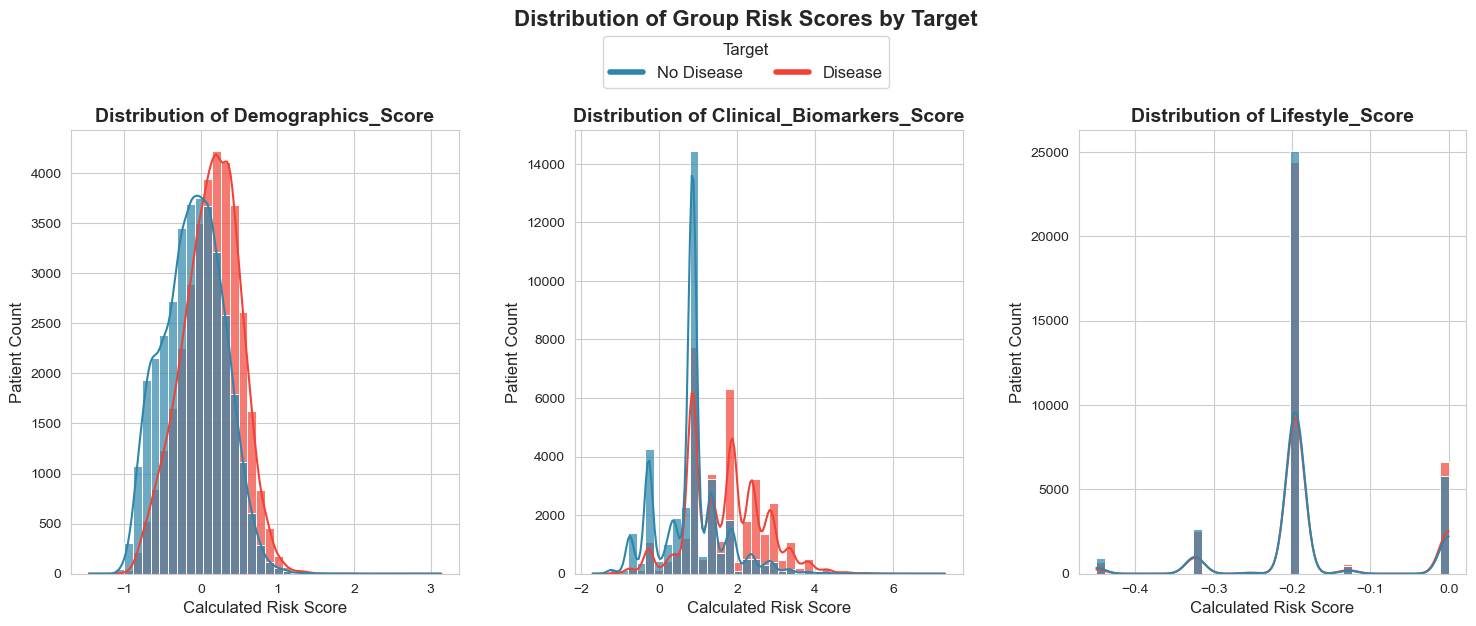

[SUCCESS] Plot saved to: P:\projects\heart disease prediction\reports\visualizations\multivariate analysis\01_Groups_Scores_Distributions.png


In [ ]:
target_column = 'target'
scored_df = df.copy()

# ---------------------------
# Groups and features
# ---------------------------
groups_by_original_features = {
    'Demographics_Score': ['Age_Years', 'Sex', 'BMI'],
    'Clinical_Biomarkers_Score': ['Cholesterol_Level', 'Glucose_Level', 'BP_level', 'Pulse_Pressure'],
    'Lifestyle_Score': ['Smoking_Status', 'Alcohol_Intake', 'Physical_Activity']
}

# ---------------------------
# Preprocess data
# ---------------------------
X = df.drop(columns=[target_column])
X_transformed = preprocessor.transform(X)

# Convert sparse to dense if needed
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

df_transformed = pd.DataFrame(
    X_transformed,
    columns=preprocessor.get_feature_names_out(),
    index=df.index
)

# ---------------------------
# Compute scores
# ---------------------------
for group_name, original_features_list in groups_by_original_features.items():
    # Select transformed features for this group
    group_cols = [c for c in df_transformed.columns if any(orig in c for orig in original_features_list)]
    # Keep only features present in coefficients
    group_cols = [c for c in group_cols if c in coefficients.index]
    
    if group_cols:
        scored_df[group_name] = df_transformed[group_cols].dot(coefficients[group_cols])
    else:
        scored_df[group_name] = 0.0

# ---------------------------
# Convert target to string for plotting
# ---------------------------
scored_df[target_column] = scored_df[target_column].map({0: 'No Disease', 1: 'Disease'})

# ---------------------------
# Plot histograms
# ---------------------------
score_columns = list(groups_by_original_features.keys())
palette = {'No Disease': '#2E86AB', 'Disease': '#F24236'}

fig, axes = plt.subplots(1, len(score_columns), figsize=(6 * len(score_columns), 6), sharey=False)
if len(score_columns) == 1:
    axes = [axes]

for i, score_col in enumerate(score_columns):
    ax = axes[i]
    sns.histplot(
        data=scored_df,
        x=score_col,
        hue=target_column,
        bins=40,
        palette=palette,
        kde=True,
        alpha=0.7,
        ax=ax
    )
    ax.set_title(f'Distribution of {score_col}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Calculated Risk Score', fontsize=12)
    ax.set_ylabel('Patient Count', fontsize=12)
    if ax.get_legend() is not None:
        ax.get_legend().remove()

# ---------------------------
# Title + Shared Legend
# ---------------------------
fig.suptitle('Distribution of Group Risk Scores by Target', fontsize=16, fontweight='bold', y=1.05)

handles = [Line2D([0],[0], color=c, lw=4) for c in palette.values()]
labels = list(palette.keys())
fig.legend(handles, labels, title='Target', loc='upper center', ncol=2, frameon=True, fontsize=12, title_fontsize=12, bbox_to_anchor=(0.5, 1.02))

# Adjust layout
fig.subplots_adjust(top=0.85, wspace=0.3)

# ---------------------------
# Save figure robustly
# ---------------------------
PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'multivariate analysis'
PLOT_DIR.mkdir(parents=True, exist_ok=True)

img_path = PLOT_DIR / '01_Groups_Scores_Distributions.png'
if img_path.exists():
    img_path.unlink()

plt.savefig(img_path, bbox_inches='tight', dpi=150)
plt.show()
print(f"[SUCCESS] Plot saved to: {img_path.resolve()}")

* **`Clinical_Biomarkers_Score` (Primary Driver)**
    This score, composed of cardiovascular and metabolic indicators (BP, Cholesterol, Glucose), is the **strongest predictor** of the target. Higher scores are clearly associated with the "Disease" group, confirming that these vitals are the dominant drivers of the model.

* **`DemographicsScore` (Secondary Driver)**
    This score, combining Age, BMI, and Sex, is a **secondary contributor** to the overall risk. It shows a moderate positive correlation with the "Disease" group but is less influential than the Vitals score.

* **`Lifestyle_Score` (Confounding Factor)**
    This score shows a **counter-intuitive relationship** where lower (more protective) lifestyle scores are associated with the "Disease" group. This indicates a confounding effect: the at-risk population in this dataset has healthier lifestyle habits that are being overpowered by the significant negative impact of their poor vitals.

[INFO] Using existing folder: P:\projects\heart disease prediction\reports\visualizations\multivariate analysis


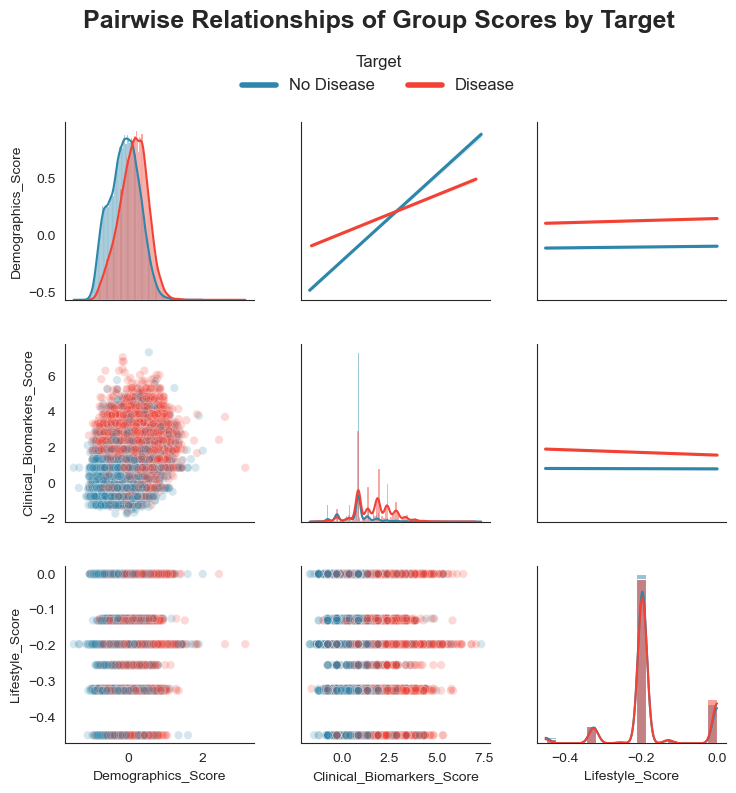

[SUCCESS] Plot saved at: P:\projects\heart disease prediction\reports\visualizations\multivariate analysis\02_Pairwise_Group_Score_Relationships.png

Correlation between scores and target:
Demographics_Score: Pearson=0.290, Spearman=0.288
Clinical_Biomarkers_Score: Pearson=0.441, Spearman=0.454
Lifestyle_Score: Pearson=0.037, Spearman=0.035


In [ ]:
# ==============================================================================
# Pairwise Group Score Relationships + Correlations
# ==============================================================================
# --- 1. Prepare Data ---
score_cols = ['Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']
target_col = 'target'

# Drop rows with missing scores or target to avoid empty plots
plot_df = scored_df.dropna(subset=score_cols + [target_col]).copy()

# Ensure target is numeric for plotting
if plot_df[target_col].dtype == object or str(plot_df[target_col].dtype).startswith('category'):
    plot_df['target_bin'] = plot_df[target_col].map({'No Disease': 0, 'Disease': 1})
else:
    plot_df['target_bin'] = plot_df[target_col]

# --- 2. PairGrid for Scores ---
sns.set_style("white")

PAIRGRID_PALETTE = {0: "#2E86AB", 1: "#F24236"}
g = sns.PairGrid(
    plot_df,
    vars=score_cols,
    hue='target_bin',
    palette=PAIRGRID_PALETTE,
    diag_sharey=False
)
g.map_lower(sns.scatterplot, alpha=0.2)
g.map_diag(lambda x, color, **kwargs: sns.histplot(x, color=color, kde=True, **kwargs))
g.map_upper(lambda x, y, color, **kwargs: sns.regplot(x=x, y=y, scatter=False, line_kws={'color': color}, **kwargs))

# --- 3. Title and Legend positioning ---
g.fig.suptitle(
    'Pairwise Relationships of Group Scores by Target',
    fontsize=18, fontweight='bold', y=1.05
)

handles = [Line2D([0], [0], color=c, lw=4) for c in PAIRGRID_PALETTE.values()]
labels = ['No Disease', 'Disease']
g.fig.legend(
    handles=handles,
    labels=labels,
    title='Target',
    loc='upper center',
    bbox_to_anchor=(0.5, 1.01),
    ncol=len(labels),
    frameon=False,
    fontsize=12,
    title_fontsize=12
)

# Adjust subplot spacing so title & legend don't overlap
g.fig.subplots_adjust(top=0.90, hspace=0.25, wspace=0.25)

# --- 4. Save figure ---
# Use absolute path to existing reports folder outside src
PLOT_DIR = Path.cwd().parent.parent / 'reports' / 'visualizations' / 'multivariate analysis'

# Do not create folder if it exists
if PLOT_DIR.is_dir():
    print(f"[INFO] Using existing folder: {PLOT_DIR.resolve()}")
else:
    PLOT_DIR.mkdir(parents=True, exist_ok=True)
    print(f"[INFO] Created folder: {PLOT_DIR.resolve()}")

img_path = PLOT_DIR / '02_Pairwise_Group_Score_Relationships.png'

# Overwrite image if it exists
plt.savefig(img_path, bbox_inches='tight', dpi=150)
plt.show()
print(f"[SUCCESS] Plot saved at: {img_path.resolve()}")

# --- 5. Check Linearity (Pearson & Spearman correlations) ---
print("\nCorrelation between scores and target:")
for col in score_cols:
    temp_df = plot_df[[col, 'target_bin']].dropna()
    if len(temp_df) > 1:
        pearson = pearsonr(temp_df[col], temp_df['target_bin'])[0]
        spearman = spearmanr(temp_df[col], temp_df['target_bin'])[0]
        print(f"{col}: Pearson={pearson:.3f}, Spearman={spearman:.3f}")
    else:
        print(f"{col}: Not enough data to calculate correlation.")

# Cleanup
del plot_df['target_bin']

### risk score creation


[XGBoost] Best balancer: RandomOverSampler
[XGBoost] Best mean CV ROC AUC: 0.7771
[XGBoost] Unified Score ROC AUC on full data: 0.779
[SAVED] Plot stored at: P:\projects\reports\visualizations\multivariate_analysis\03_Unified_Risk_Score_Distribution(probability).png


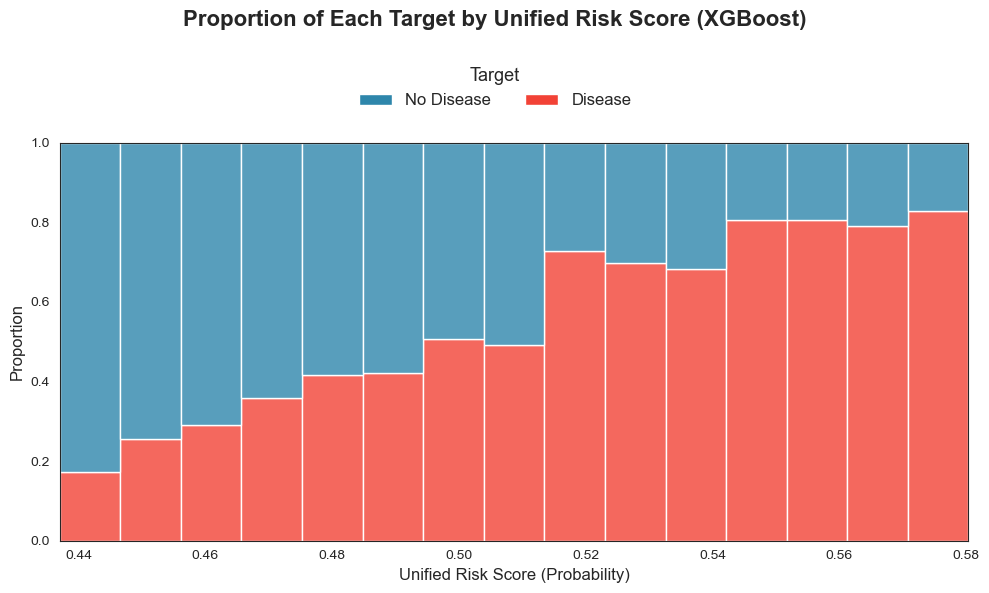

In [ ]:
# ----------------------------
# Setup
# ----------------------------
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

# ----------------------------
# 1. Ensure target_label exists
# ----------------------------
if 'target_label' not in scored_df.columns:
    target_mapping = {0: 'No Disease', 1: 'Disease'}
    if scored_df['target'].dtype == object or str(scored_df['target'].dtype).startswith('category'):
        scored_df['target_label'] = scored_df['target']
    else:
        scored_df['target_label'] = scored_df['target'].map(target_mapping)

# ----------------------------
# 2. Prepare features and target
# ----------------------------
score_cols = ['Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']
X = scored_df[score_cols].copy()
y = scored_df['target_label'].map({'No Disease': 0, 'Disease': 1}).copy()

# ----------------------------
# 3. Train/test split
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ----------------------------
# 4. Define balancers
# ----------------------------
balancers = {
    "SMOTE": SMOTE(random_state=42),
    "RandomOverSampler": RandomOverSampler(random_state=42),
}

# ----------------------------
# 5. XGBoost Optuna objective
# ----------------------------
def xgb_objective(trial):
    balancer_name = trial.suggest_categorical("balancer", list(balancers.keys()))
    balancer = balancers[balancer_name]
    X_res, y_res = balancer.fit_resample(X_train, y_train)
    xgb = XGBClassifier(
        use_label_encoder=False,
        eval_metric='auc',
        random_state=42,
        max_depth=2,
        min_child_weight=20,
        subsample=0.5,
        colsample_bytree=0.5,
        reg_alpha=50.0,
        reg_lambda=200.0,
        gamma=10.0,
        n_estimators=60,
        learning_rate=0.01
    )
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []
    for train_idx, valid_idx in skf.split(X_res, y_res):
        X_tr, X_val = X_res.iloc[train_idx], X_res.iloc[valid_idx]
        y_tr, y_val = y_res.iloc[train_idx], y_res.iloc[valid_idx]
        xgb.fit(X_tr, y_tr, verbose=False)
        y_pred = xgb.predict_proba(X_val)[:, 1]
        aucs.append(roc_auc_score(y_val, y_pred))
    return float(np.mean(aucs))

xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=10, show_progress_bar=False)

print(f"\n[XGBoost] Best balancer: {xgb_study.best_trial.params['balancer']}")
print(f"[XGBoost] Best mean CV ROC AUC: {xgb_study.best_trial.value:.4f}")

# ----------------------------
# 6. Retrain XGBoost final model
# ----------------------------
best_balancer_xgb = balancers[xgb_study.best_trial.params['balancer']]
X_train_bal_xgb, y_train_bal_xgb = best_balancer_xgb.fit_resample(X_train, y_train)

final_xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42,
    max_depth=2,
    min_child_weight=20,
    subsample=0.5,
    colsample_bytree=0.5,
    reg_alpha=50.0,
    reg_lambda=200.0,
    gamma=10.0,
    n_estimators=60,
    learning_rate=0.01
)
final_xgb.fit(X_train_bal_xgb, y_train_bal_xgb)

scored_df['Unified_Score_XGB'] = final_xgb.predict_proba(X)[:, 1]
auc_xgb = roc_auc_score(y, scored_df['Unified_Score_XGB'])
print(f"[XGBoost] Unified Score ROC AUC on full data: {auc_xgb:.3f}")

# ----------------------------
# 7. Plot Unified Risk Score Distribution
# ----------------------------
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(
    data=scored_df,
    x='Unified_Score_XGB',
    hue='target_label',
    bins=15,
    palette={'No Disease': '#2E86AB', 'Disease': '#F24236'},
    kde=False,
    stat="probability",
    multiple="fill",
    alpha=0.8,
    legend=False,
    ax=ax
)

fig.suptitle(
    'Proportion of Each Target by Unified Risk Score (XGBoost)',
    fontsize=16,
    fontweight='bold',
    y=0.98
)

legend_handles = [
    Patch(facecolor='#2E86AB', label='No Disease'),
    Patch(facecolor='#F24236', label='Disease')
]

fig.legend(
    handles=legend_handles,
    title='Target',
    loc='upper center',
    bbox_to_anchor=(0.5, 0.91),
    ncol=2,
    frameon=False,
    fontsize=12,
    title_fontsize=13
)

ax.set_xlabel('Unified Risk Score (Probability)', fontsize=12)
ax.set_ylabel('Proportion', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.85])
ax.grid(False)  # remove gridlines

# ----------------------------
# 8. Save outside src
# ----------------------------
OUTSIDE_DIR = PROJECT_ROOT.parent / 'reports' / 'visualizations' / 'multivariate_analysis'
OUTSIDE_DIR.mkdir(parents=True, exist_ok=True)

img_path = OUTSIDE_DIR / '03_Unified_Risk_Score_Distribution(probability).png'
if img_path.exists():
    img_path.unlink()

plt.savefig(img_path, bbox_inches='tight', dpi=150)
print(f"[SAVED] Plot stored at: {img_path.resolve()}")
plt.show()

### Quantile binning - Risk group creation

[INFO] Saving plots into existing directory: P:\projects\heart disease prediction\reports\visualizations\multivariate analysis


Best trial: 24. Best value: 0.791901: 100%|██████████| 50/50 [01:01<00:00,  1.23s/it]


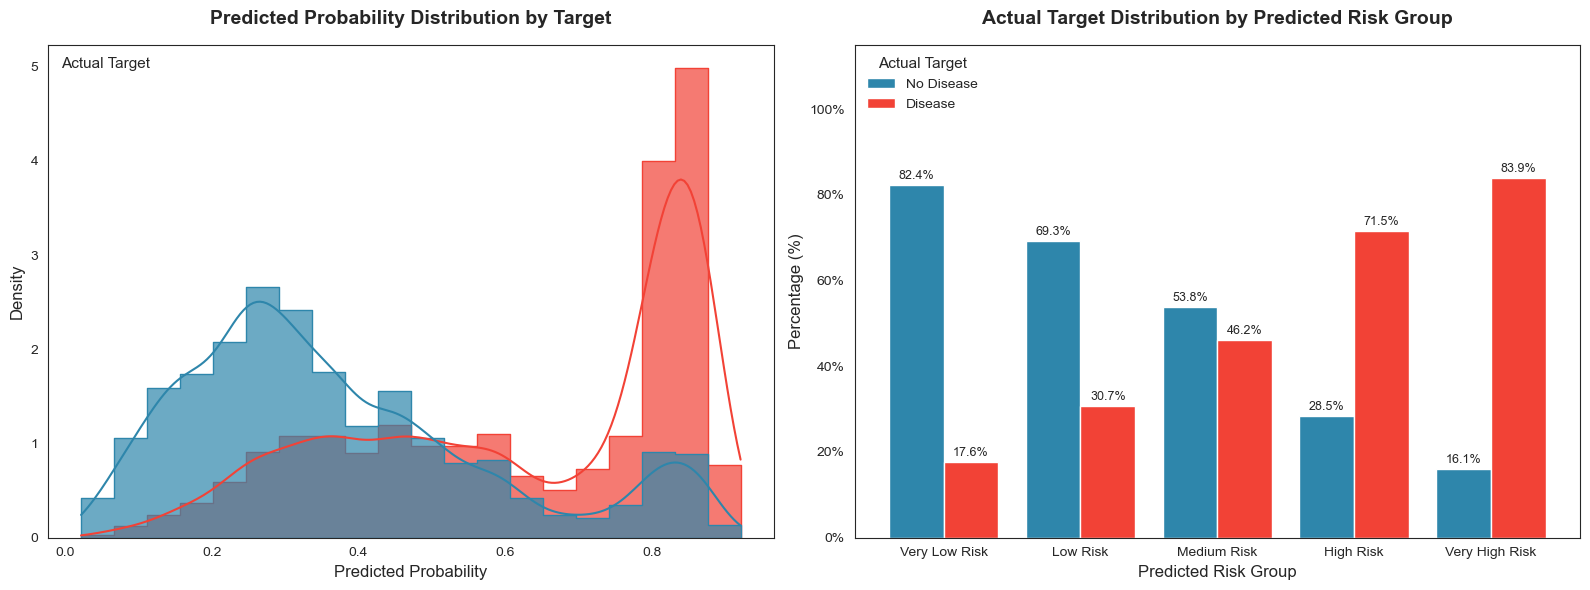

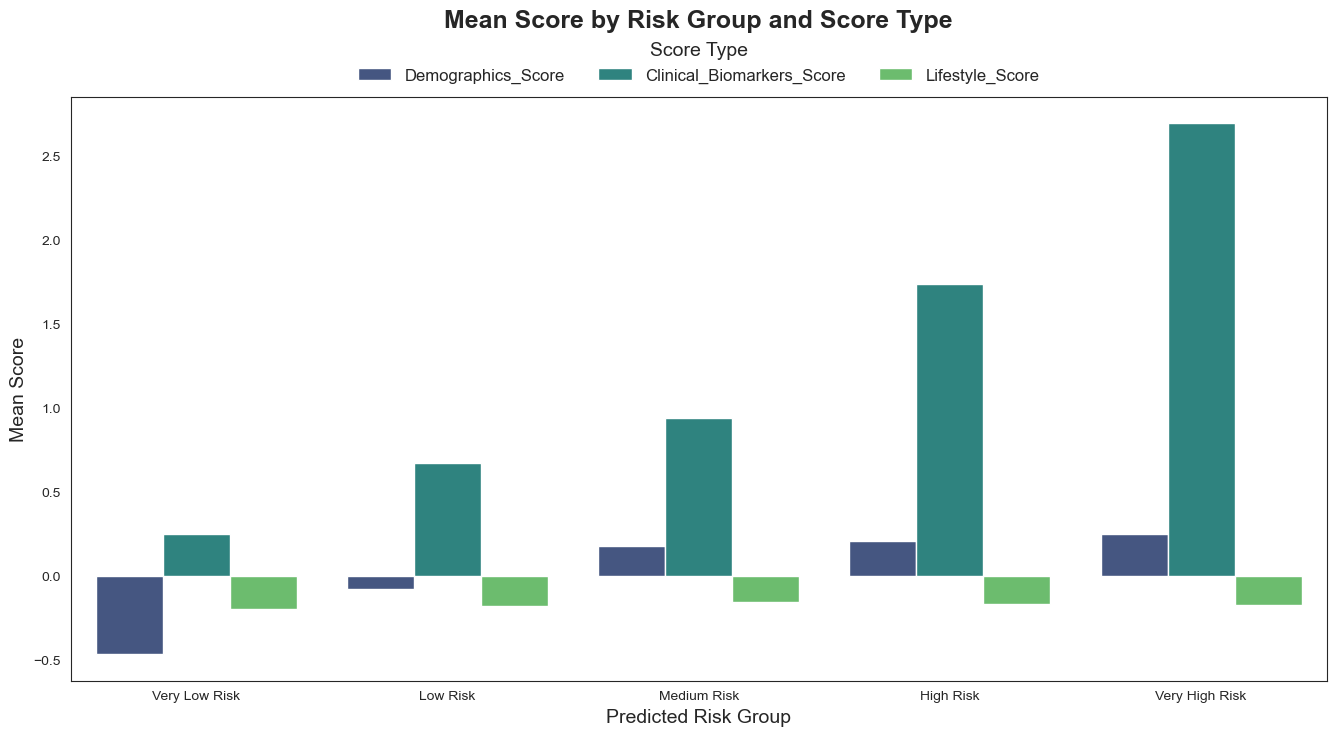

[SUCCESS] Grouped mean bar chart saved at: P:\projects\heart disease prediction\reports\visualizations\multivariate analysis\04_MeanScore_by_RiskGroups_and_GroupScores.png


In [ ]:
# ------------------------ 2. CONFIGURATION ---------------------------------
RANDOM_STATE = 42
N_SPLITS_CV = 5
N_TRIALS = 50
N_JOBS = -1

# ------------------------ 3. PROJECT ROOT & PLOT DIRECTORY -----------------
CURRENT_DIR = Path.cwd()
PROJECT_ROOT = CURRENT_DIR
while 'src' in [p.name.lower() for p in PROJECT_ROOT.parents] or PROJECT_ROOT.name.lower() == 'src':
    PROJECT_ROOT = PROJECT_ROOT.parent

PLOT_DIR = PROJECT_ROOT / 'reports' / 'visualizations' / 'multivariate analysis'
print(f"[INFO] Saving plots into existing directory: {PLOT_DIR.resolve()}")

# ------------------------ 4. DATA PREPARATION --------------------------------
target_column = 'target'
target_mapping = {0: 'No Disease', 1: 'Disease'}

# Drop rows where target is NaN to avoid errors in model training
scored_df = scored_df.dropna(subset=[target_column])

if 'target_label' not in scored_df.columns:
    scored_df['target_label'] = scored_df[target_column].map(target_mapping)

if scored_df[target_column].dtype == object or str(scored_df[target_column].dtype).startswith('category'):
    reverse_mapping = {v: k for k, v in target_mapping.items()}
    scored_df[target_column] = scored_df['target_label'].map(reverse_mapping)

features = ['Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score']
X = scored_df[features].copy()
y = scored_df[target_column].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)
X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
X_test, y_test = X_test.reset_index(drop=True), y_test.reset_index(drop=True)

# ------------------------ 5. BALANCERS ---------------------------------------
def get_balancer(name, y_data):
    if name == "SMOTE":
        class_counts = y_data.value_counts()
        min_class_count = class_counts.min()
        k_neighbors = min(5, min_class_count - 1) if min_class_count > 1 else 1
        try:
            return SMOTE(random_state=RANDOM_STATE, k_neighbors=k_neighbors)
        except Exception:
            return RandomOverSampler(random_state=RANDOM_STATE)
    else:
        return RandomOverSampler(random_state=RANDOM_STATE)

BALANCER_NAMES = ['SMOTE', 'RandomOverSampler']

# ------------------------ 6. OPTUNA OBJECTIVE -------------------------------
def objective(trial):
    balancer_name = trial.suggest_categorical("balancer", BALANCER_NAMES)
    balancer = get_balancer(balancer_name, y_train)

    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "random_state": RANDOM_STATE,
        "use_label_encoder": False,
        "n_estimators": 100,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 100.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 100.0, log=True)
    }

    model = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)
    auc_scores = []

    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        if len(np.unique(y_tr)) < 2 or len(np.unique(y_val)) < 2:
            continue

        try:
            X_res, y_res = balancer.fit_resample(X_tr, y_tr)
        except Exception:
            X_res, y_res = X_tr.copy(), y_tr.copy()

        model.fit(X_res, y_res)
        preds = model.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, preds))

    return float(np.mean(auc_scores)) if auc_scores else 0.0

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=N_JOBS)

best_params = study.best_params.copy()
best_balancer_name = best_params.pop("balancer")
best_balancer = get_balancer(best_balancer_name, y_train)

# ------------------------ 7. FINAL MODEL TRAINING ---------------------------
X_train_bal, y_train_bal = best_balancer.fit_resample(X_train, y_train)
final_model = XGBClassifier(**best_params, n_estimators=100)
final_model.fit(X_train_bal, y_train_bal)
y_proba_test = final_model.predict_proba(X_test)[:, 1]

# ------------------------ 8. RESULTS & RISK BINNING --------------------------
results_df = pd.DataFrame({
    "Actual": y_test.values,
    "Actual_Label": y_test.map(target_mapping).values,
    "Pred_Prob": y_proba_test
})
for col in features:
    results_df[col] = X_test[col].values

risk_labels = ["Very Low Risk", "Low Risk", "Medium Risk", "High Risk", "Very High Risk"]
quantiles = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

try:
    risk_bins, bin_edges = pd.qcut(
        results_df["Pred_Prob"], q=quantiles, labels=risk_labels, retbins=True, duplicates="drop"
    )
except ValueError:
    n_unique_bins = len(np.unique(np.quantile(results_df["Pred_Prob"], quantiles))) - 1
    risk_bins, bin_edges = pd.qcut(
        results_df["Pred_Prob"], q=n_unique_bins, labels=risk_labels[:n_unique_bins], retbins=True, duplicates="drop"
    )

risk_cat_type = CategoricalDtype(categories=risk_labels[:len(np.unique(risk_bins))], ordered=True)
results_df["Pred_Risk_Quantile"] = pd.Categorical(risk_bins, dtype=risk_cat_type)

# ------------------------ 9. GRAPH 1 + 2 (Subplots) --------------------------
sns.set_style("white")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graph 1: Predicted Probability Distribution
sns.histplot(
    data=results_df, x="Pred_Prob", hue="Actual_Label", bins=20,
    palette={"No Disease": "#2E86AB", "Disease": "#F24236"},
    alpha=0.7, stat="density", element="step", common_norm=False, kde=True, ax=axes[0]
)
axes[0].set_title("Predicted Probability Distribution by Target", fontsize=14, fontweight="bold", pad=15)
axes[0].set_xlabel("Predicted Probability", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend(title="Actual Target", title_fontsize=11, loc='upper left', frameon=False)

# Graph 2: Risk Group Distribution
risk_target_prop = pd.crosstab(
    results_df["Pred_Risk_Quantile"], results_df["Actual_Label"], normalize='index'
) * 100
risk_target_prop.plot(
    kind='bar', ax=axes[1], color={"No Disease": "#2E86AB", "Disease": "#F24236"},
    width=0.8, rot=0
)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f%%', fontsize=9, padding=2)
axes[1].set_title("Actual Target Distribution by Predicted Risk Group", fontsize=14, fontweight="bold", pad=15)
axes[1].set_xlabel("Predicted Risk Group", fontsize=12)
axes[1].set_ylabel("Percentage (%)", fontsize=12)
axes[1].set_ylim(0, 115)
axes[1].yaxis.set_major_formatter(PercentFormatter())
axes[1].legend(title="Actual Target", title_fontsize=11, loc='upper left', frameon=False)

plt.tight_layout()
img_path_12 = PLOT_DIR / '03_Risk_Analysis.png'
fig.savefig(img_path_12, bbox_inches='tight', dpi=150)
plt.show()

# ------------------------ 10. GRAPH 3: Mean Score by Risk Group --------------------------
mean_df = results_df.groupby("Pred_Risk_Quantile")[features]\
                    .mean().reset_index()\
                    .melt(id_vars="Pred_Risk_Quantile", var_name="Score", value_name="Mean_Score")

plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=mean_df,
    x="Pred_Risk_Quantile",
    y="Mean_Score",
    hue="Score",
    palette="viridis",
    dodge=True
)

# --- Customize the plot ---
ax.set_title("Mean Score by Risk Group and Score Type", fontsize=18, fontweight="bold", pad=50)  # move title higher
ax.set_xlabel("Predicted Risk Group", fontsize=14)
ax.set_ylabel("Mean Score", fontsize=14)

ax.legend(
    title="Score Type",
    title_fontsize=14,
    fontsize=12,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.12),
    ncol=len(features),
    frameon=False
)

plt.tight_layout(pad=3.0)

# --- Save the plot ---
img_path = PLOT_DIR / '04_MeanScore_by_RiskGroups_and_GroupScores.png'
plt.savefig(img_path, bbox_inches='tight', dpi=150)
plt.show()

print(f"[SUCCESS] Grouped mean bar chart saved at: {img_path.resolve()}")


In [ ]:
results_df.columns

Index(['Actual', 'Actual_Label', 'Pred_Prob', 'Demographics_Score',
       'Clinical_Biomarkers_Score', 'Lifestyle_Score', 'Pred_Risk_Quantile'],
      dtype='object')

In [ ]:
scored_df.columns

Index(['Age_Years', 'Sex', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol_Level',
       'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake',
       'Physical_Activity', 'target', 'BMI', 'BP_level', 'Pulse_Pressure',
       'Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score',
       'target_label', 'Unified_Score_XGB'],
      dtype='object')

In [ ]:
# rename 'Unified_Score_XGB' to 'Unified_Risk_Score'
scored_df = scored_df.rename(columns={'Unified_Score_XGB': 'Unified_Risk_Score'})

In [ ]:
# Merge scores from scored_df and prediction columns from results_df into df

# Merge scores from scored_df
df = df.merge(
    scored_df[['Demographics_Score', 'Clinical_Biomarkers_Score', 
               'Lifestyle_Score', 'Unified_Risk_Score']],
    left_index=True, right_index=True, how='left'
)

# Merge Pred_Prob and Pred_Risk_Quantile from results_df (only available for test set indices)
if 'Pred_Prob' in results_df.columns and 'Pred_Risk_Quantile' in results_df.columns:
    df.loc[results_df.index, 'Pred_Prob'] = results_df['Pred_Prob']
    df.loc[results_df.index, 'Pred_Risk_Quantile'] = results_df['Pred_Risk_Quantile']

df.columns
del scored_df, results_df

In [ ]:
# Define DATA_PROCESSED_DIR if not already defined
DATA_PROCESSED_DIR = Path(os.environ.get('DATA_PROCESSED_DIR', PROJECT_ROOT / 'data/processed')).resolve()

# Save the DataFrame with error handling and config path
output_path = DATA_PROCESSED_DIR / "processed_data.parquet"
output_path.parent.mkdir(parents=True, exist_ok=True)
if output_path.exists():
    output_path.unlink()
try:
    df.to_parquet(output_path, index=False)
    file_size_mb = output_path.stat().st_size / (1024 * 1024)
except Exception as e:
    traceback.print_exc()

In [ ]:
df.columns

Index(['Age_Years', 'Sex', 'Systolic_BP', 'Diastolic_BP', 'Cholesterol_Level',
       'Glucose_Level', 'Smoking_Status', 'Alcohol_Intake',
       'Physical_Activity', 'target', 'BMI', 'BP_level', 'Pulse_Pressure',
       'Demographics_Score', 'Clinical_Biomarkers_Score', 'Lifestyle_Score',
       'Unified_Risk_Score', 'Pred_Prob', 'Pred_Risk_Quantile'],
      dtype='object')